In [1]:
import obspy
from obspy.taup import TauPyModel

from multiprocessing import Pool
from obspy import read,UTCDateTime,Trace,read_inventory,read_events
from obspy.io.sac.sactrace import SACTrace
from obspy.imaging.beachball import beachball,beach
from obspy.clients.fdsn import Client
from obspy.signal.trigger import recursive_sta_lta

import os
from glob import glob
import numpy as np
from collections import defaultdict
import pandas as pd
from scipy import signal
import subprocess
from sklearn import preprocessing
import geopy.distance


#para plotar as figuras
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, MinuteLocator, SecondLocator, DateFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,FixedLocator,StrMethodFormatter
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

from datetime import datetime,timedelta,date
from tqdm import tqdm

from shapely.geometry.polygon import LinearRing
from matplotlib.patches import Rectangle

import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import requests
import csv
import xml.etree.ElementTree as ET
import ast

# INPUT DATA

In [8]:
EVENT_GLIDER = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/EVENTS_GLIDERS/'
EVENT_RSBR = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/DATA_EVENTS/'
QUAKEXML_FOLDER = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/EVENTS/'
FOLDER_OUTPUT = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/'
TABLE_EVENTS_RECORDED = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/FIGURAS/STATISTICS/table_events_selected.csv'

In [2]:
EVENT_GLIDER = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/OUTPUT/EVENTS_GLIDERS/'
EVENT_RSBR = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/DATA_EVENTS/'
QUAKEXML_FOLDER = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/OUTPUT/EVENTS/'
FOLDER_OUTPUT = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/OUTPUT/'
TABLE_EVENTS_RECORDED = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/OUTPUT/FIGURAS/STATISTICS/table_events_selected.csv'

In [3]:
df = pd.read_csv(TABLE_EVENTS_RECORDED)

FileNotFoundError: [Errno 2] No such file or directory: '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/OUTPUT/FIGURAS/STATISTICS/table_events_selected.csv'

In [10]:
df_events = obspy.read_events(glob(QUAKEXML_FOLDER+'CMTSOLUTIONS*')[0])

In [11]:
df.head(2)

Unnamed: 0            filename_mseed name_glider Phase          ev_ID  \
0           0  GL.G170F..HHH.D.2017.199       G170F    pP  201707180205A   
1           1  GL.G180R..HHH.D.2018.302       G180R    pP  201810290654A   

                       ev_time  ev_lat  ev_long  ev_depth   distance  ...  \
0  2017-07-18T02:05:24.600000Z  -16.70   -73.65      66.4  28.403816  ...   
1  2018-10-29T06:54:25.700000Z  -57.55   -66.60      20.7  36.885802  ...   

                                       lon_dive_info  \
0  [-44.620018, -44.620087, -44.620155, -44.62022...   
1  [-42.52124, -42.521225, -42.521164, -42.521107...   

                                     depth_dive_info  \
0  [-844.34503, -849.7975, -855.3275, -860.9325, ...   
1  [-902.75653, -906.93726, -911.18365, -915.3794...   

                     srn_per_band  \
0  [1.1, 0.9, 0.9, 1.0, 2.3, 1.6]   
1  [1.0, 1.0, 1.0, 0.9, 1.1, 2.0]   

                                sta_lta_max_per_band  \
0  [2.2394495748887953, 1.6993015006496563, 2.676...   
1  [1.5918091422657556, 1.731094158706432, 1.6891...   

                                      noise_per_band  \
0  [-38.102619478425034, -45.80864085690297, -40....   
1  [-50.24175128155632, -51.653489479356914, -56....   

   automatic_event_detection  automatic_time_residual  year ev_depth_round  \
0                       True                    -1.55  2017           75.0   
1                       True                    -4.53  2018           25.0   

  manual_event_detection  
0                  False  
1                  False  

[2 rows x 30 columns]

In [12]:
ev_local = []
for i in df.iterrows():
    for j in df_events:
        if i[1]['ev_ID'] == j.event_descriptions[0].text:
            ev_local.append(j.origins[0].region)

In [13]:
df['local'] = ev_local

In [14]:
df.head(2).sort_values('distance')

Unnamed: 0            filename_mseed name_glider Phase          ev_ID  \
0           0  GL.G170F..HHH.D.2017.199       G170F    pP  201707180205A   
1           1  GL.G180R..HHH.D.2018.302       G180R    pP  201810290654A   

                       ev_time  ev_lat  ev_long  ev_depth   distance  ...  \
0  2017-07-18T02:05:24.600000Z  -16.70   -73.65      66.4  28.403816  ...   
1  2018-10-29T06:54:25.700000Z  -57.55   -66.60      20.7  36.885802  ...   

                                     depth_dive_info  \
0  [-844.34503, -849.7975, -855.3275, -860.9325, ...   
1  [-902.75653, -906.93726, -911.18365, -915.3794...   

                     srn_per_band  \
0  [1.1, 0.9, 0.9, 1.0, 2.3, 1.6]   
1  [1.0, 1.0, 1.0, 0.9, 1.1, 2.0]   

                                sta_lta_max_per_band  \
0  [2.2394495748887953, 1.6993015006496563, 2.676...   
1  [1.5918091422657556, 1.731094158706432, 1.6891...   

                                      noise_per_band  \
0  [-38.102619478425034, -45.80864085690297, -40....   
1  [-50.24175128155632, -51.653489479356914, -56....   

  automatic_event_detection  automatic_time_residual  year  ev_depth_round  \
0                      True                    -1.55  2017            75.0   
1                      True                    -4.53  2018            25.0   

  manual_event_detection               local  
0                  False  NEAR COAST OF PERU  
1                  False       DRAKE PASSAGE  

[2 rows x 31 columns]

In [15]:
SNR_max_lst = []
STA_LTA_max_lst = []

for i in df.iterrows():
    SNR_max_lst.append(max(ast.literal_eval((i[1]['srn_per_band']))))
    STA_LTA_max_lst.append(max(ast.literal_eval((i[1]['sta_lta_max_per_band']))))

In [16]:
df['SNR_max'] = SNR_max_lst
df['STA_LTA_max'] = STA_LTA_max_lst

In [21]:
# Function to classify earthquake depth
def class_dep(ev_depth):
    if ev_depth <= 70:
        return 'shallow'
    elif 70 < ev_depth <= 350:
        return 'intermediate'
    else:
        return 'deep'

In [22]:
# Aplicar a função a cada linha da coluna 'profundidade'
df['depth_class'] = df['ev_depth'].apply(class_dep)


In [23]:
df_sel = df[['ev_ID','Phase','magnitude','ev_depth','depth_class','distance','SNR_max','STA_LTA_max','automatic_time_residual', 'local']]

In [24]:
df_sel.sort_values('distance').style.format(precision=2).to_latex()

'\\begin{tabular}{lllrrlrrrrl}\n & ev_ID & Phase & magnitude & ev_depth & depth_class & distance & SNR_max & STA_LTA_max & automatic_time_residual & local \\\\\n3 & 201704150819A & P & 6.27 & 164.20 & intermediate & 21.40 & 4.70 & 8.30 & -3.42 & CHILE-ARGENTINA BORDER REGION \\\\\n4 & 201611041620A & P & 6.33 & 96.20 & intermediate & 25.69 & 1.90 & 7.80 & 1.87 & CHILE-ARGENTINA BORDER REGION \\\\\n0 & 201707180205A & pP & 6.46 & 66.40 & shallow & 28.40 & 2.30 & 5.27 & -1.55 & NEAR COAST OF PERU \\\\\n1 & 201810290654A & pP & 6.33 & 20.70 & shallow & 36.89 & 2.00 & 3.24 & -4.53 & DRAKE PASSAGE \\\\\n2 & 201706140729A & P & 6.95 & 72.70 & intermediate & 62.22 & 3.70 & 9.24 & -3.80 & NEAR COAST OF CHIAPAS, MEXICO \\\\\n17 & 201612081738A & PKIKP & 7.80 & 45.50 & shallow & 137.05 & 2.00 & 4.72 & -7.75 & SOLOMON ISLANDS \\\\\n7 & 201907111708A & PKP & 6.00 & 493.10 & deep & 146.58 & 3.20 & 9.29 & 1.32 & SOLOMON ISLANDS \\\\\n15 & 201907111708A & PKIKP & 6.00 & 493.10 & deep & 146.58 & 3.10 

In [25]:
df

Unnamed: 0            filename_mseed name_glider  Phase          ev_ID  \
0            0  GL.G170F..HHH.D.2017.199       G170F     pP  201707180205A   
1            1  GL.G180R..HHH.D.2018.302       G180R     pP  201810290654A   
2            2  GL.G170E..HHH.D.2017.165       G170E      P  201706140729A   
3            3  GL.G170B..HHH.D.2017.105       G170B      P  201704150819A   
4            4  GL.G1607..HHH.D.2016.309       G1607      P  201611041620A   
5            5  GL.G180R..HHH.D.2018.286       G180R    PKP  201810131110A   
6            6  GL.G190X..HHH.D.2019.195       G190X    PKP  201907140910A   
7            7  GL.G190X..HHH.D.2019.192       G190X    PKP  201907111708A   
8            8  GL.G180L..HHH.D.2018.056       G180L    PKP  201802251744A   
9            9  GL.G2014..HHH.D.2020.085       G2014    PKP  202003250249A   
10          10  GL.G1608..HHH.D.2017.010       G1608    PKP  201701100613A   
11          11  GL.G190U..HHH.D.2019.048       G190U    PKP  201902171435A   
12          12  GL.G180L..HHH.D.2018.056       G180L  PKIKP  201802251744A   
13          13  GL.G2014..HHH.D.2020.085       G2014  PKIKP  202003250249A   
14          14  GL.G190U..HHH.D.2019.048       G190U  PKIKP  201902171435A   
15          15  GL.G190X..HHH.D.2019.192       G190X  PKIKP  201907111708A   
16          16  GL.G190X..HHH.D.2019.195       G190X  PKIKP  201907140910A   
17          17  GL.G1608..HHH.D.2016.343       G1608  PKIKP  201612081738A   

                        ev_time  ev_lat  ev_long  ev_depth    distance  ...  \
0   2017-07-18T02:05:24.600000Z  -16.70   -73.65      66.4   28.403816  ...   
1   2018-10-29T06:54:25.700000Z  -57.55   -66.60      20.7   36.885802  ...   
2   2017-06-14T07:29:07.900000Z   14.92   -92.17      72.7   62.215434  ...   
3   2017-04-15T08:19:48.300000Z  -23.20   -67.92     164.2   21.404124  ...   
4   2016-11-04T16:20:49.900000Z  -35.06   -70.98      96.2   25.685713  ...   
5   2018-10-13T11:10:26.900000Z   52.71   153.43     473.4  148.859548  ...   
6   2019-07-14T09:11:04.600000Z   -0.72   128.13      12.0  152.510997  ...   
7   2019-07-11T17:08:38.800000Z   -4.66   155.19     493.1  146.578300  ...   
8   2018-02-25T17:45:08.600000Z   -6.29   142.97      12.0  148.417358  ...   
9   2020-03-25T02:49:32.100000Z   49.11   157.87      52.6  150.584355  ...   
10  2017-01-10T06:13:55.900000Z    4.57   122.78     621.5  155.136715  ...   
11  2019-02-17T14:35:58.100000Z   -3.33   152.13     372.2  148.568806  ...   
12  2018-02-25T17:45:08.600000Z   -6.29   142.97      12.0  148.417358  ...   
13  2020-03-25T02:49:32.100000Z   49.11   157.87      52.6  150.584355  ...   
14  2019-02-17T14:35:58.100000Z   -3.33   152.13     372.2  148.568806  ...   
15  2019-07-11T17:08:38.800000Z   -4.66   155.19     493.1  146.578300  ...   
16  2019-07-14T09:11:04.600000Z   -0.72   128.13      12.0  152.510997  ...   
17  2016-12-08T17:39:00.500000Z  -10.46   161.12      45.5  137.045770  ...   

                                       noise_per_band  \
0   [-38.102619478425034, -45.80864085690297, -40....   
1   [-50.24175128155632, -51.653489479356914, -56....   
2   [-40.090801396433974, -49.12575636090834, -43....   
3   [-41.64898035233148, -48.86660614126883, -44.2...   
4   [-38.042218338530354, -41.85597469926445, -40....   
5   [-44.752458836073785, -47.30863329540381, -49....   
6   [-43.26698518070345, -47.352974404725884, -46....   
7   [-40.96094300527167, -44.09812270571671, -44.6...   
8   [-37.63808104127702, -44.99123840492537, -40.3...   
9   [-48.96729905484017, -53.91726072195788, -52.1...   
10  [-37.67842087423681, -42.31556835616117, -40.9...   
11  [-50.58646604080139, -52.552375116118235, -56....   
12  [-38.479329321084144, -45.39677291864809, -41....   
13  [-47.603947988036985, -52.69964504068285, -50....   
14  [-50.67529547918131, -52.69708941589694, -56.6...   
15  [-41.56527534921486, -44.99504218162498, -45.0...   
16  [-42.65490941725596, -46.65454213059321, -45.5

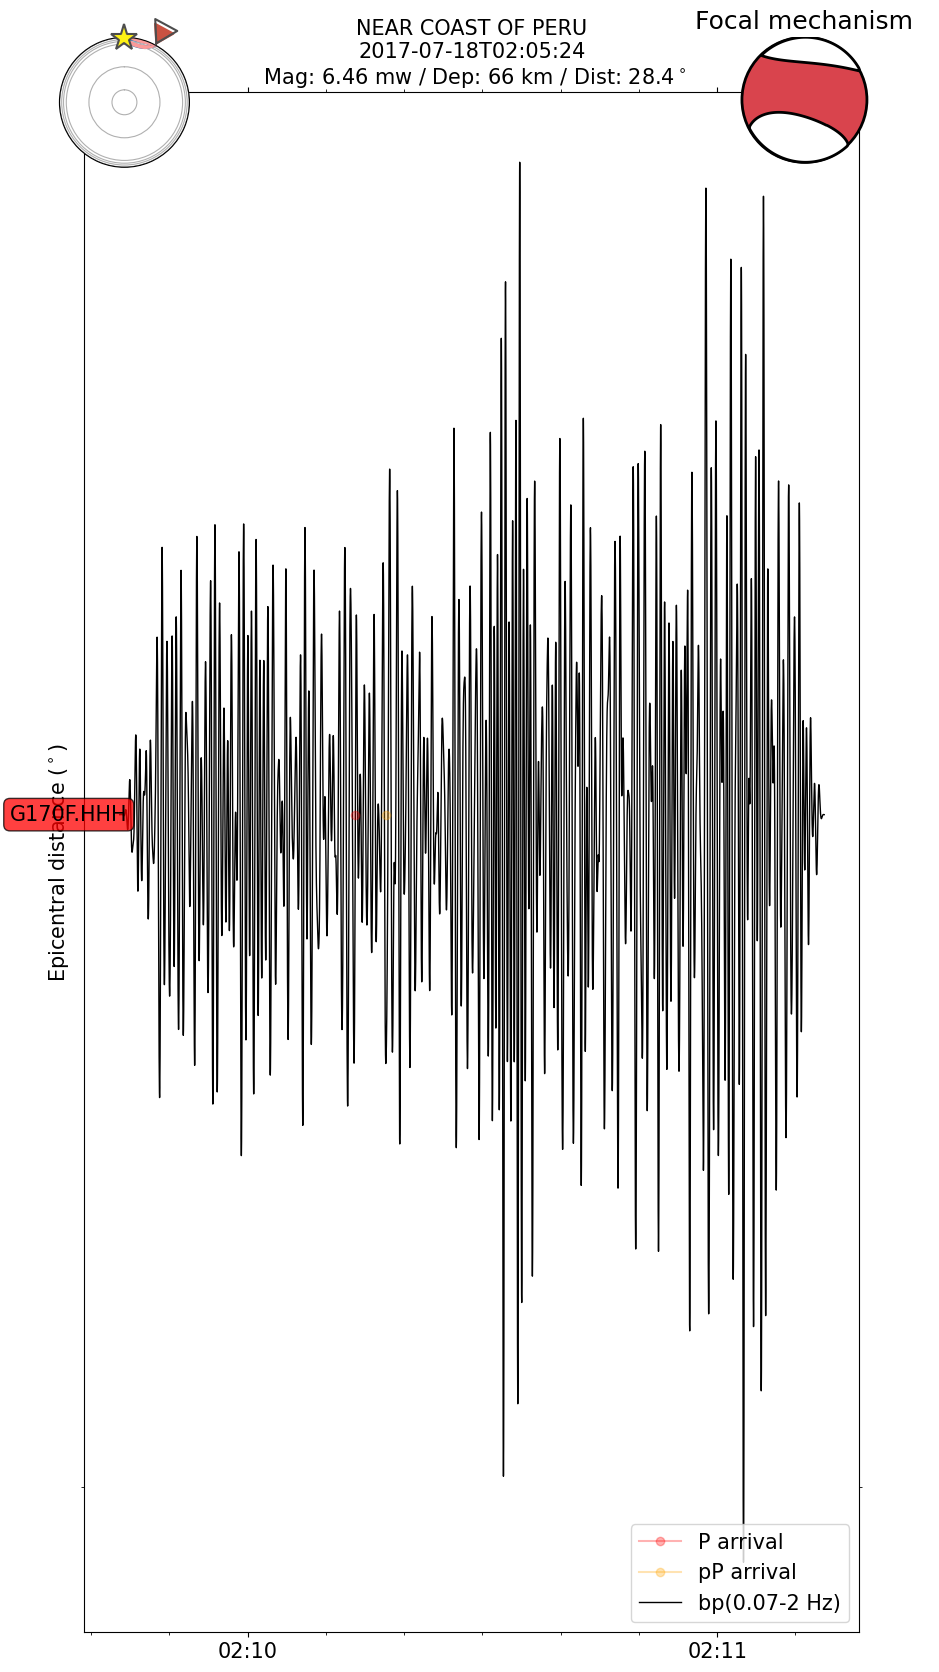

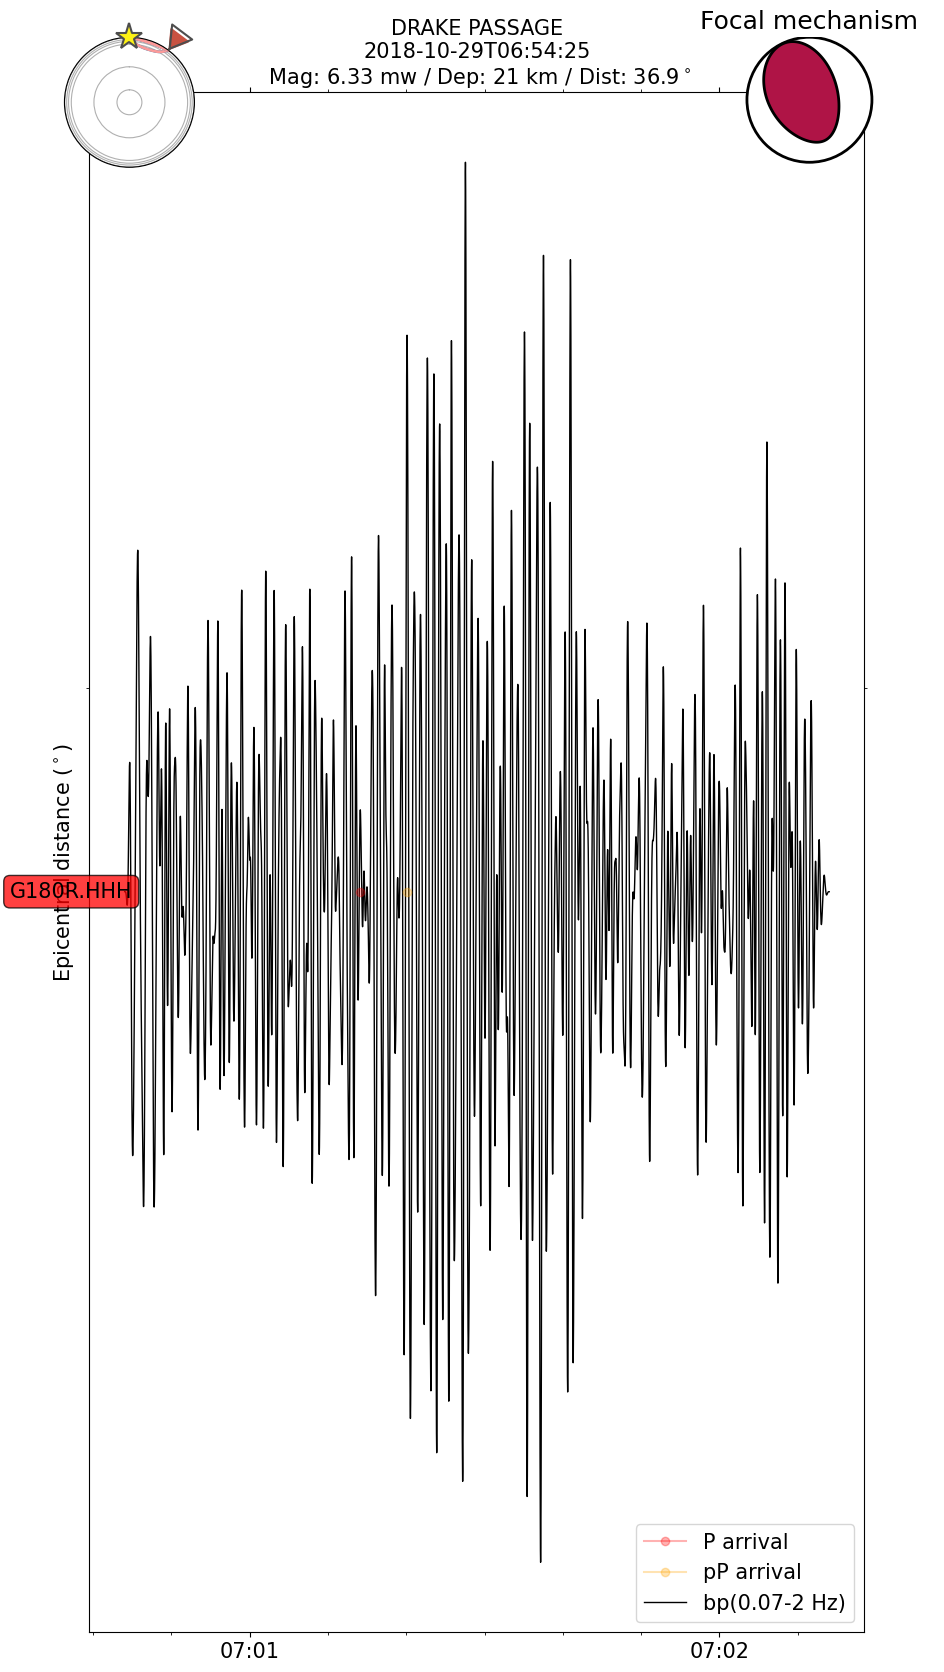

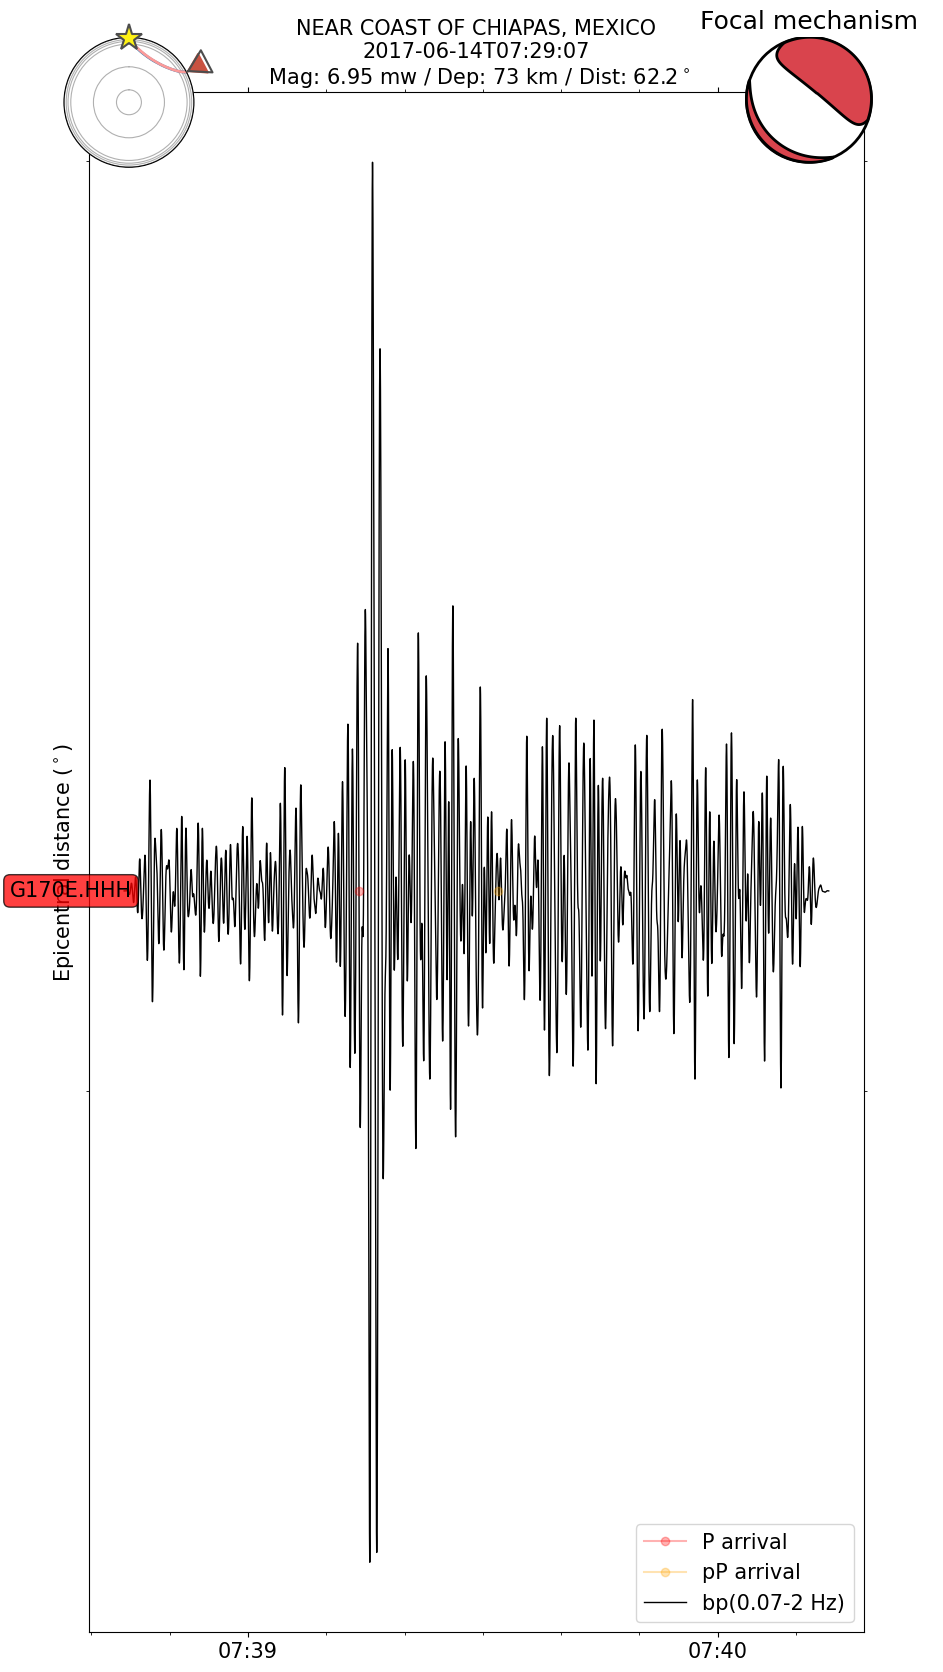

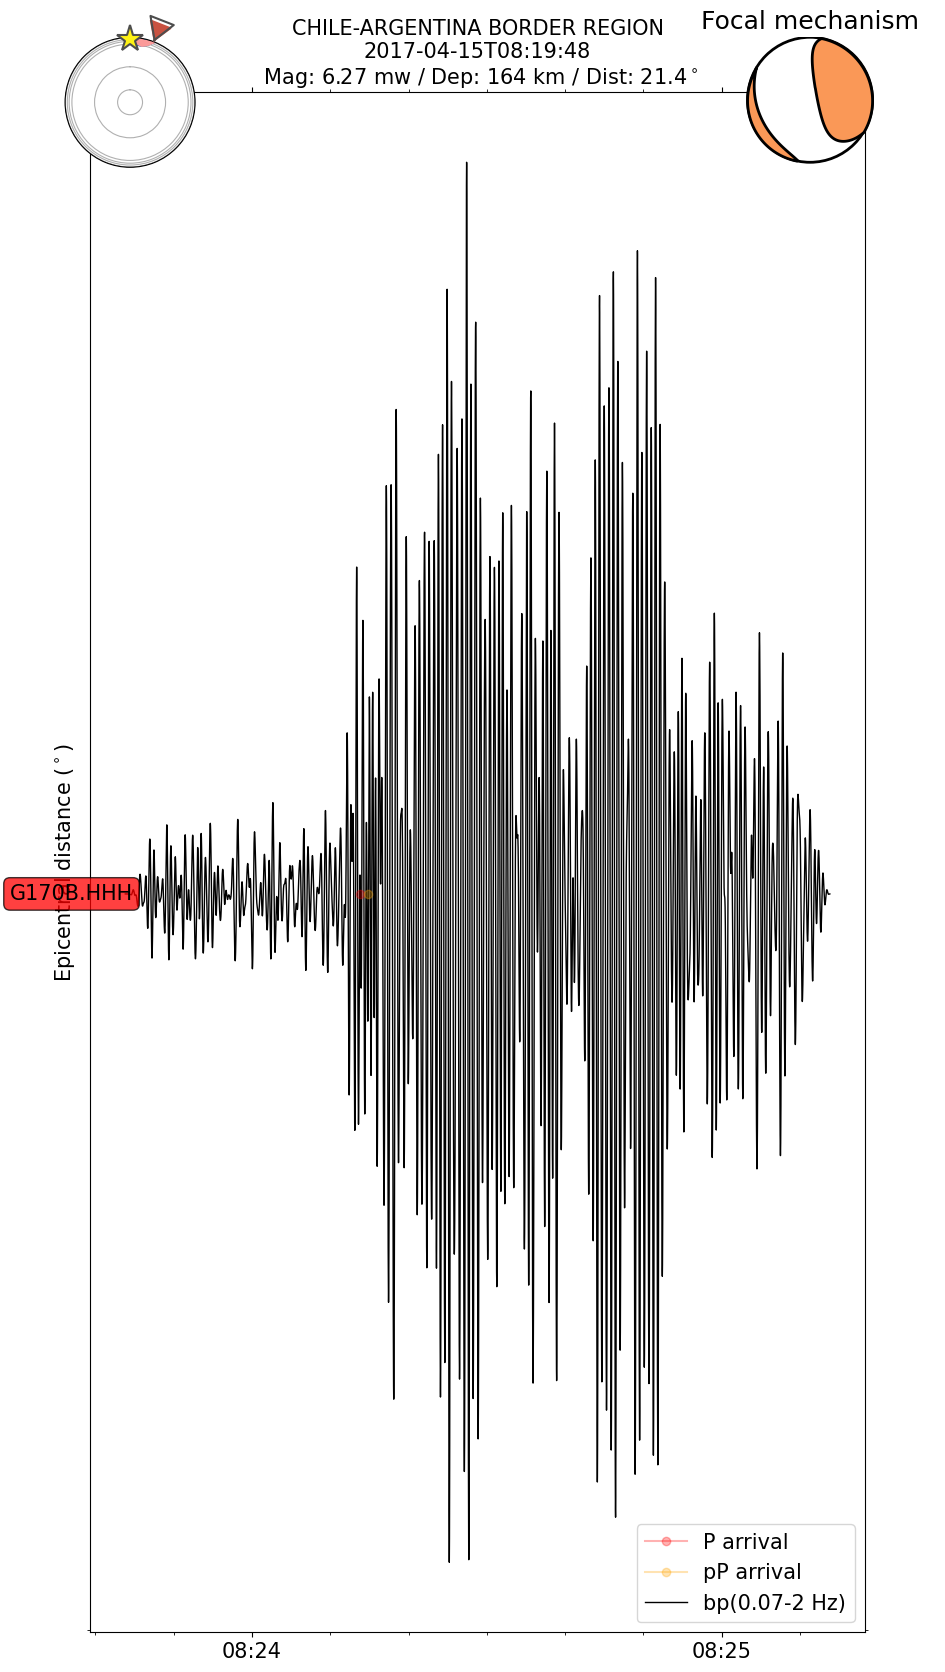

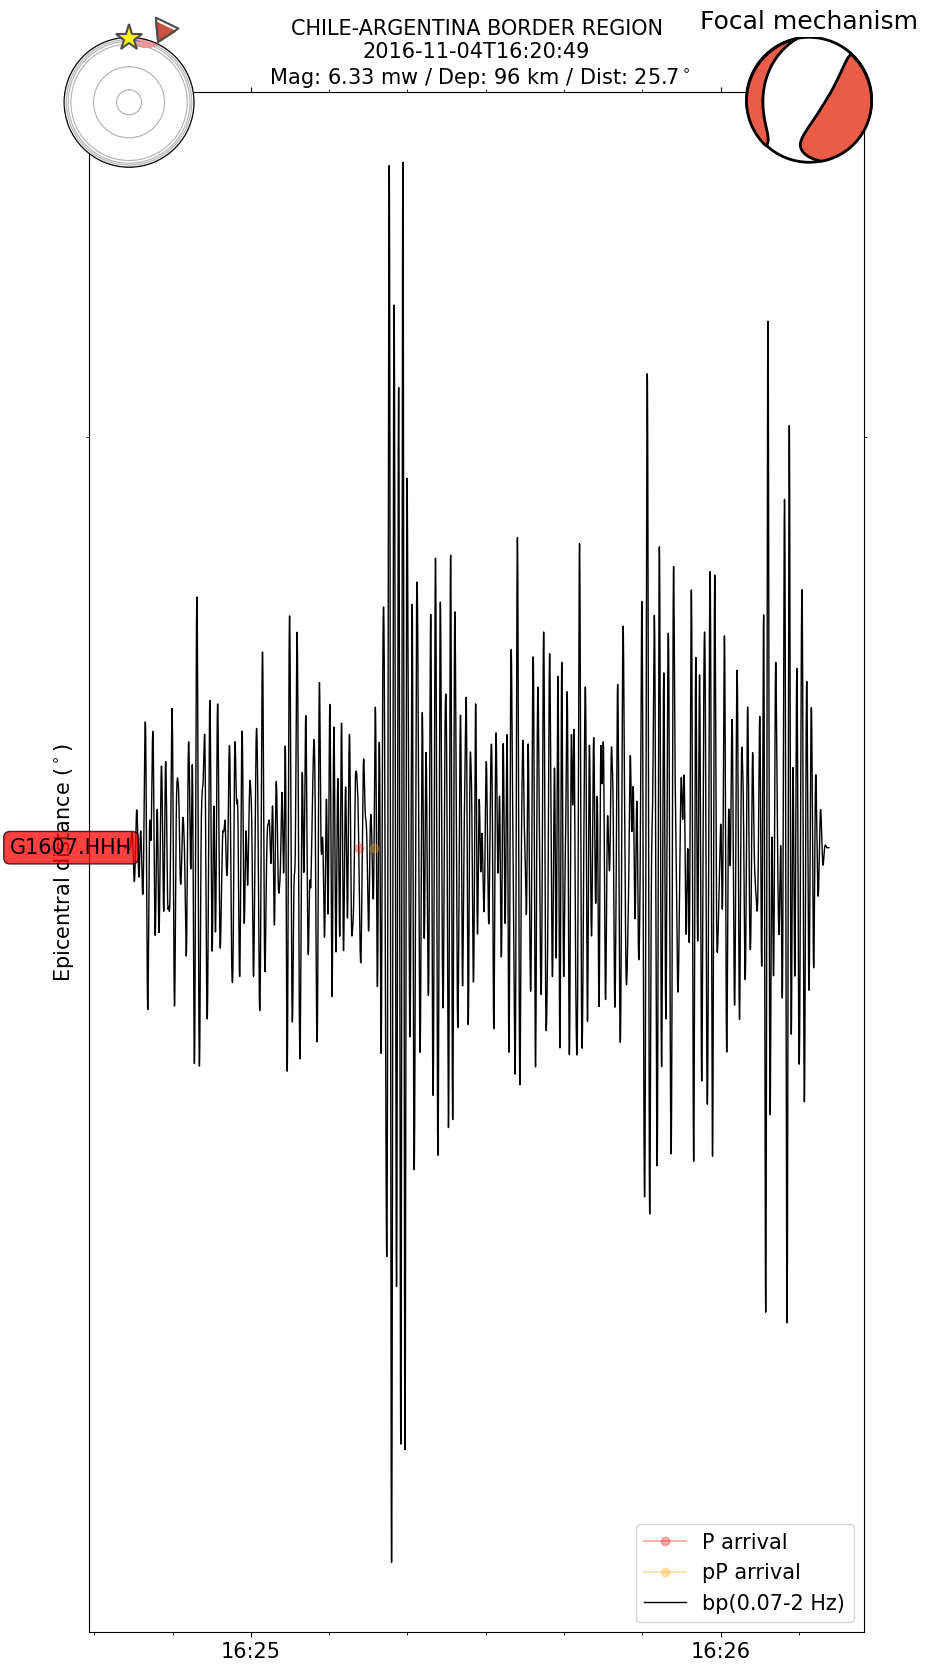

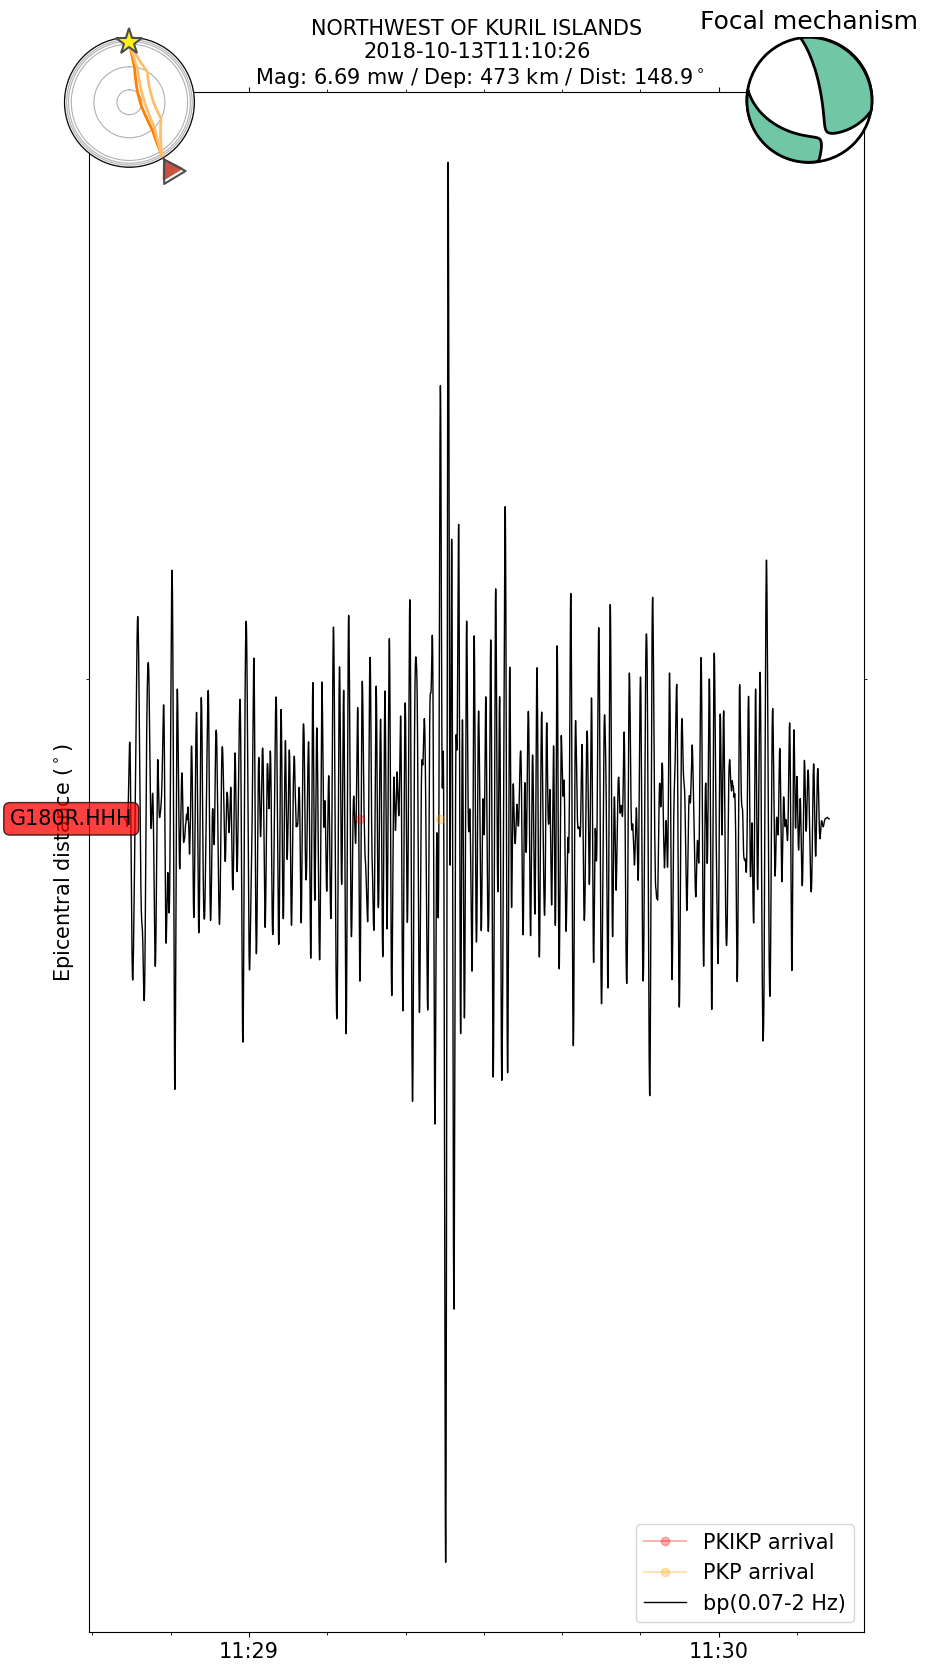

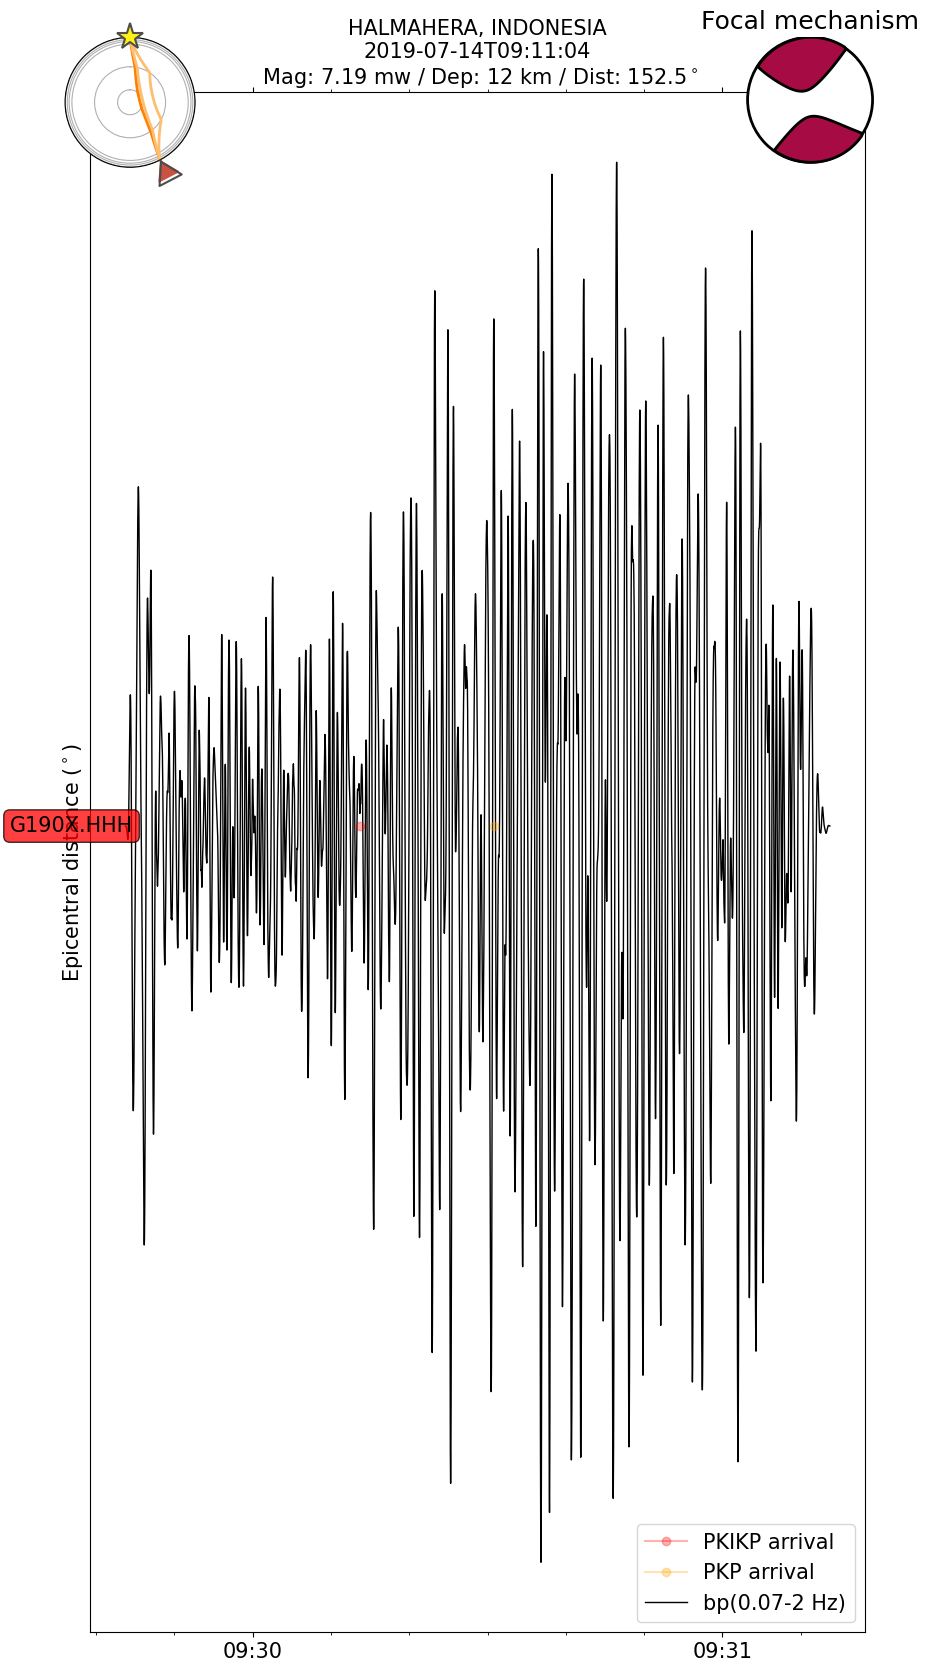

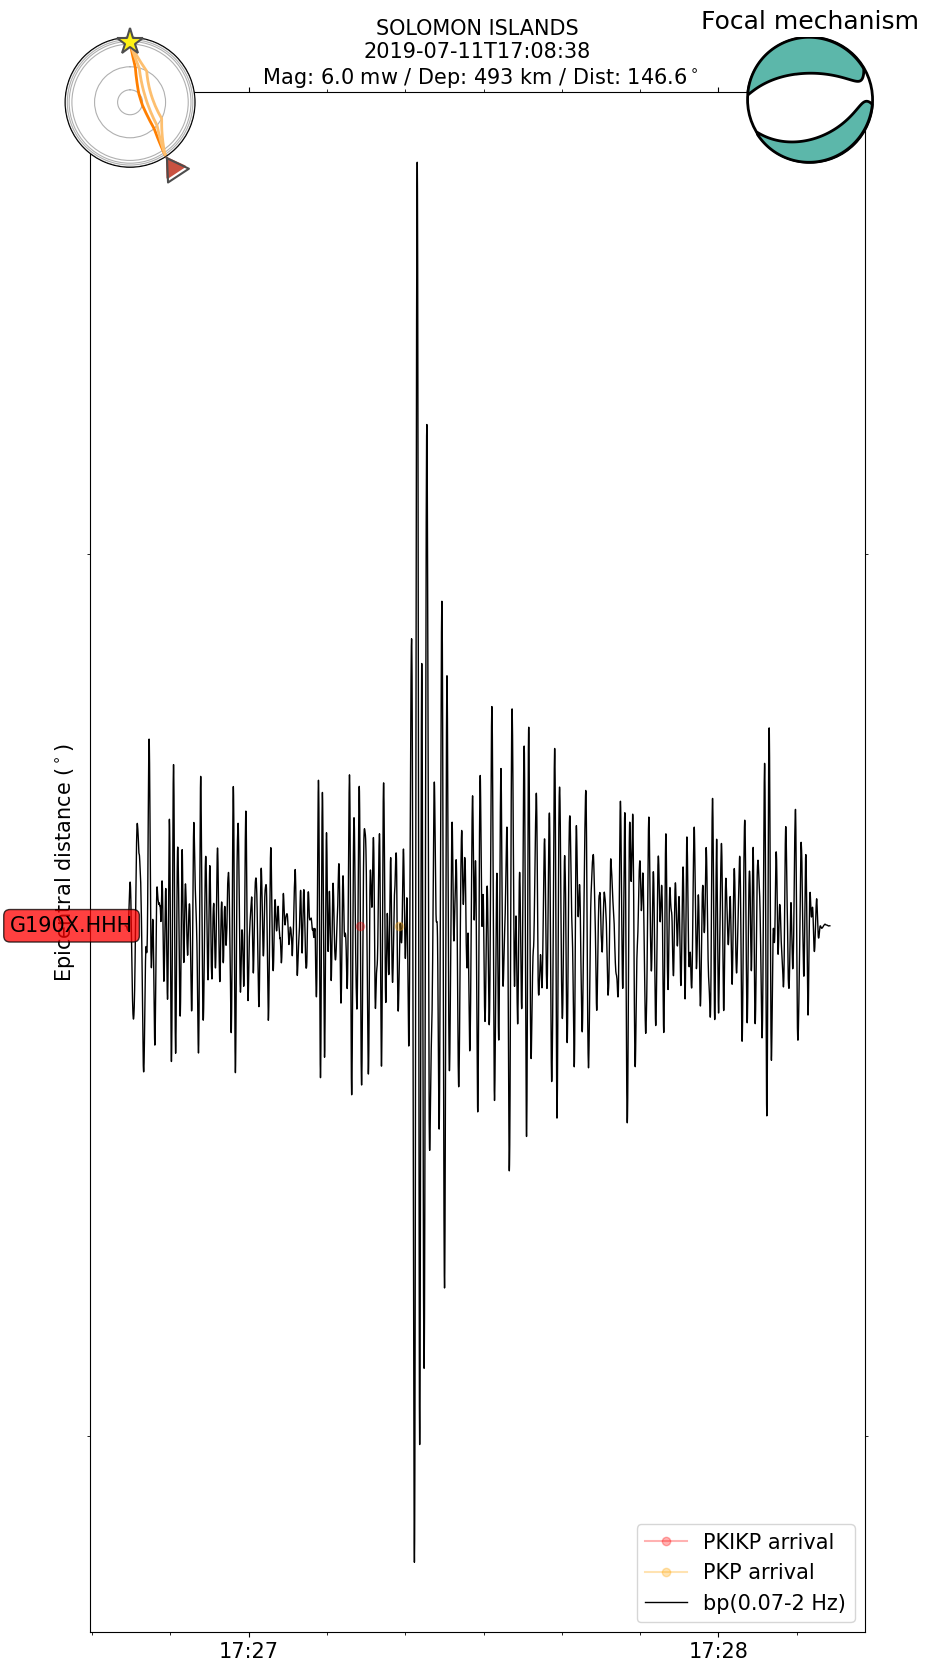

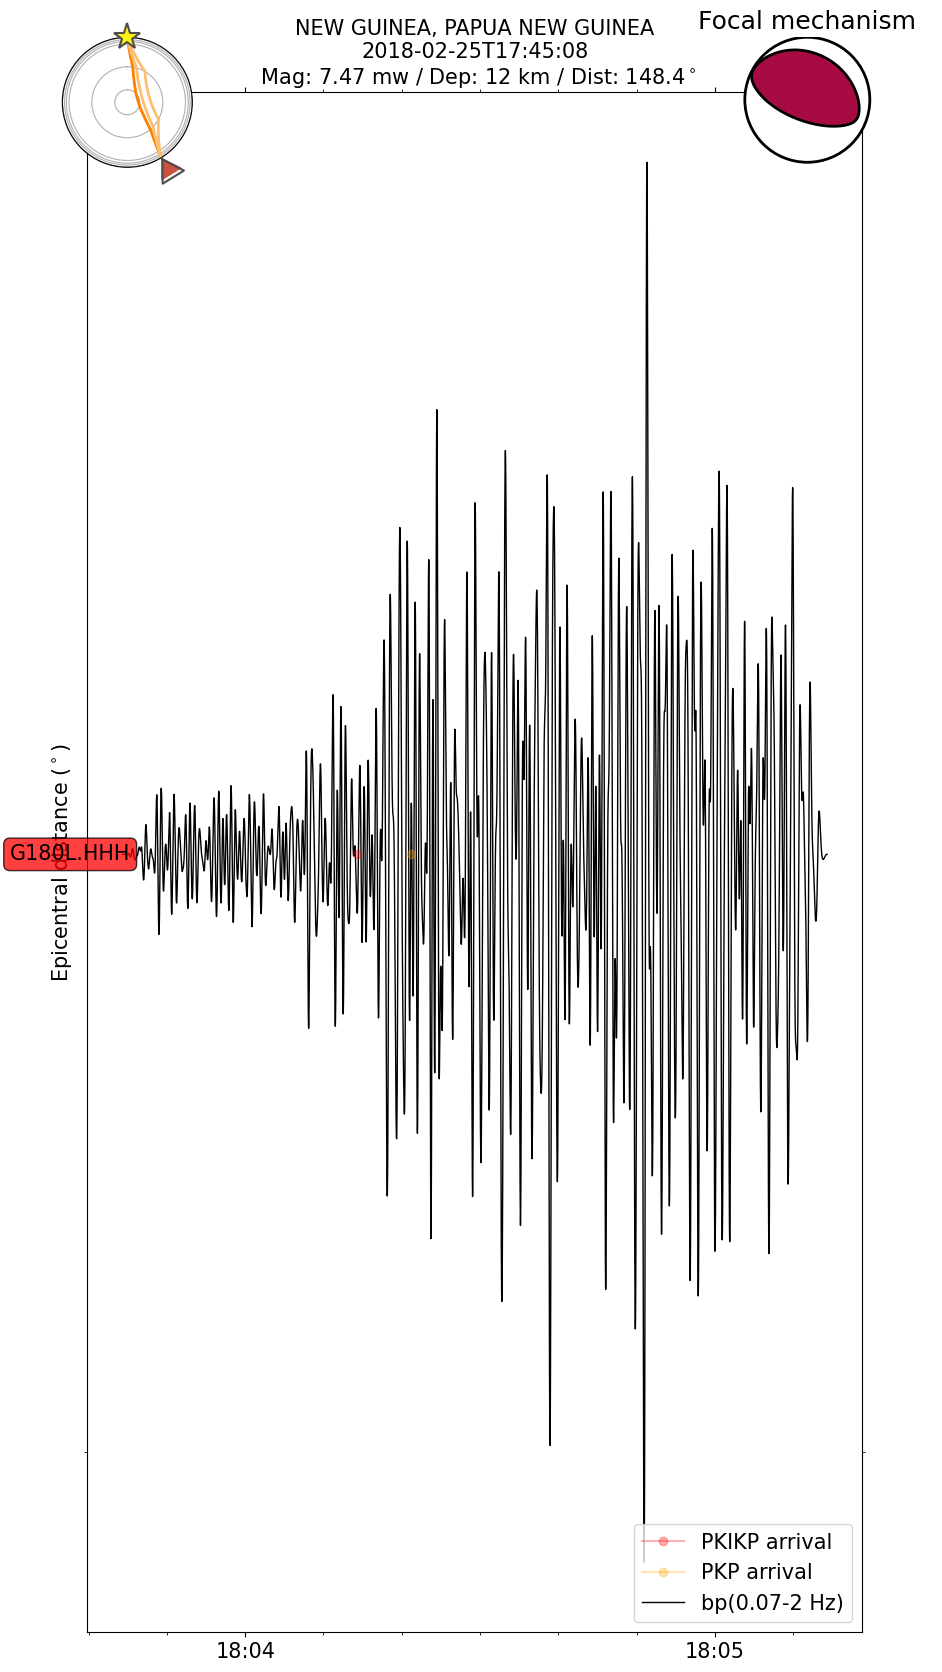

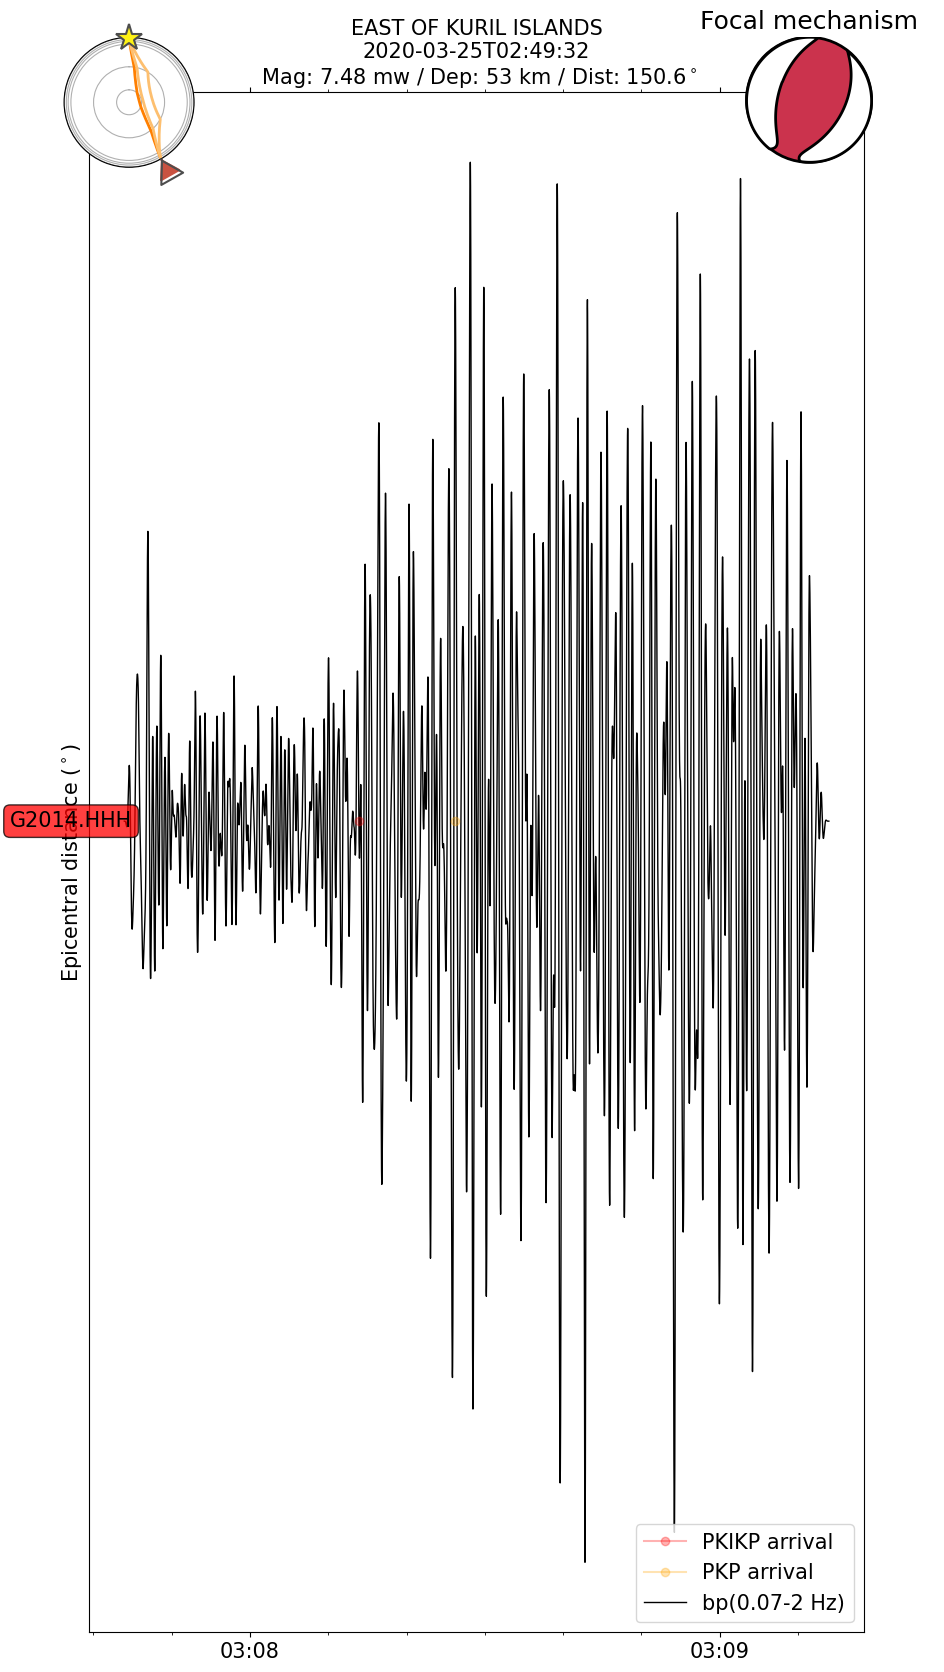

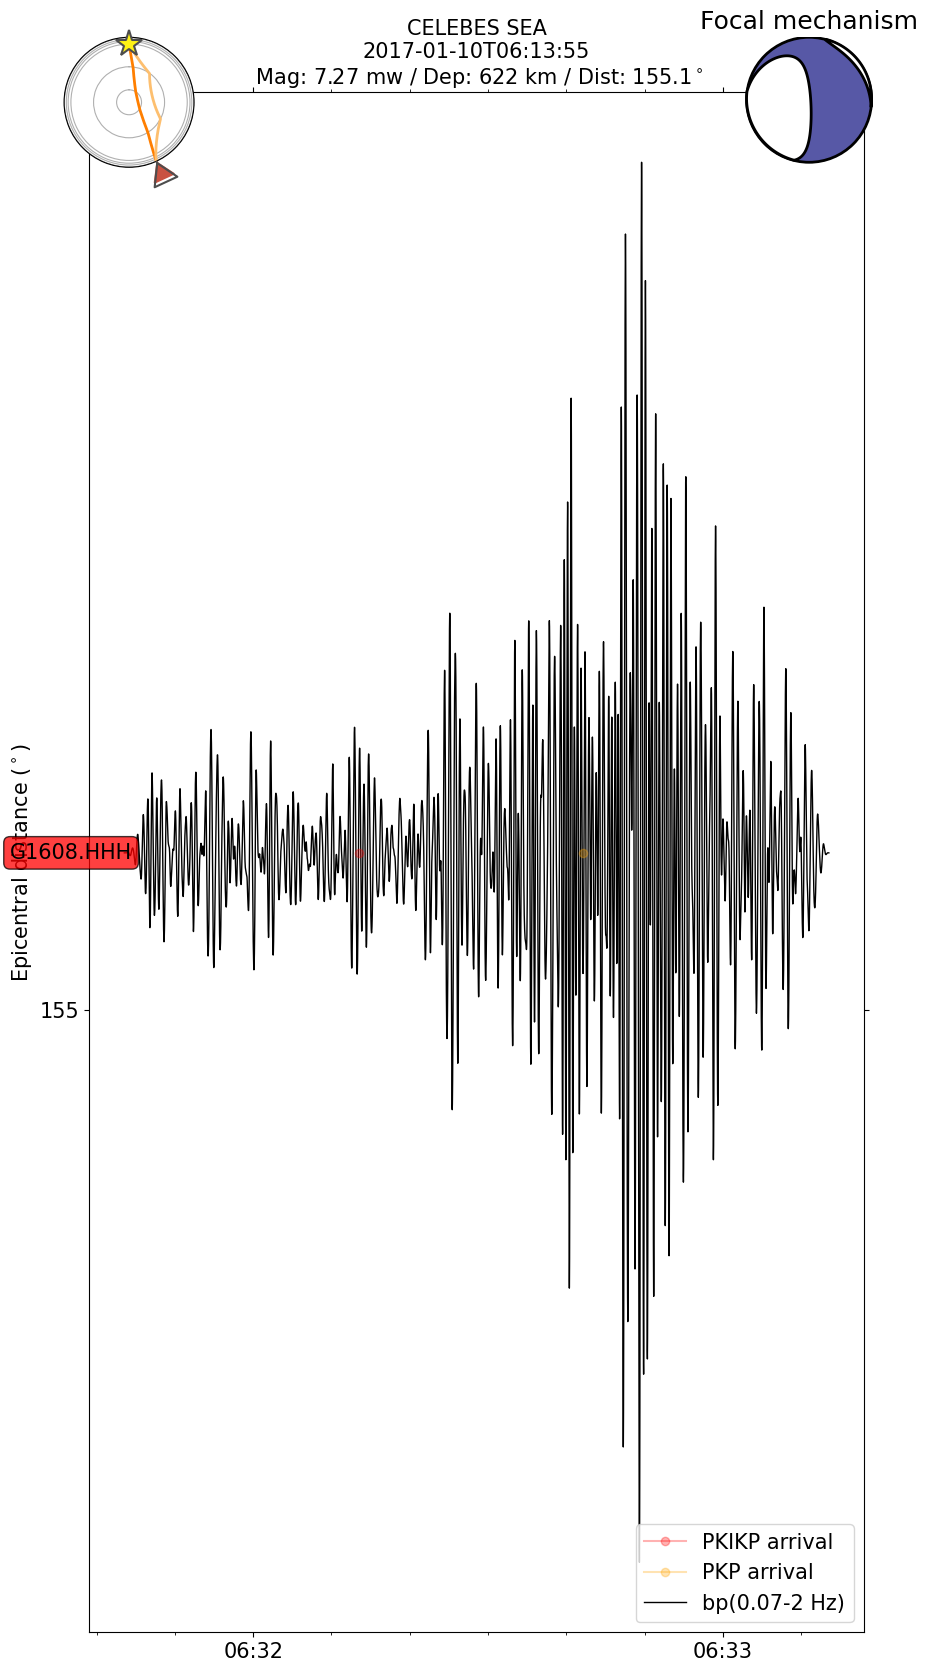

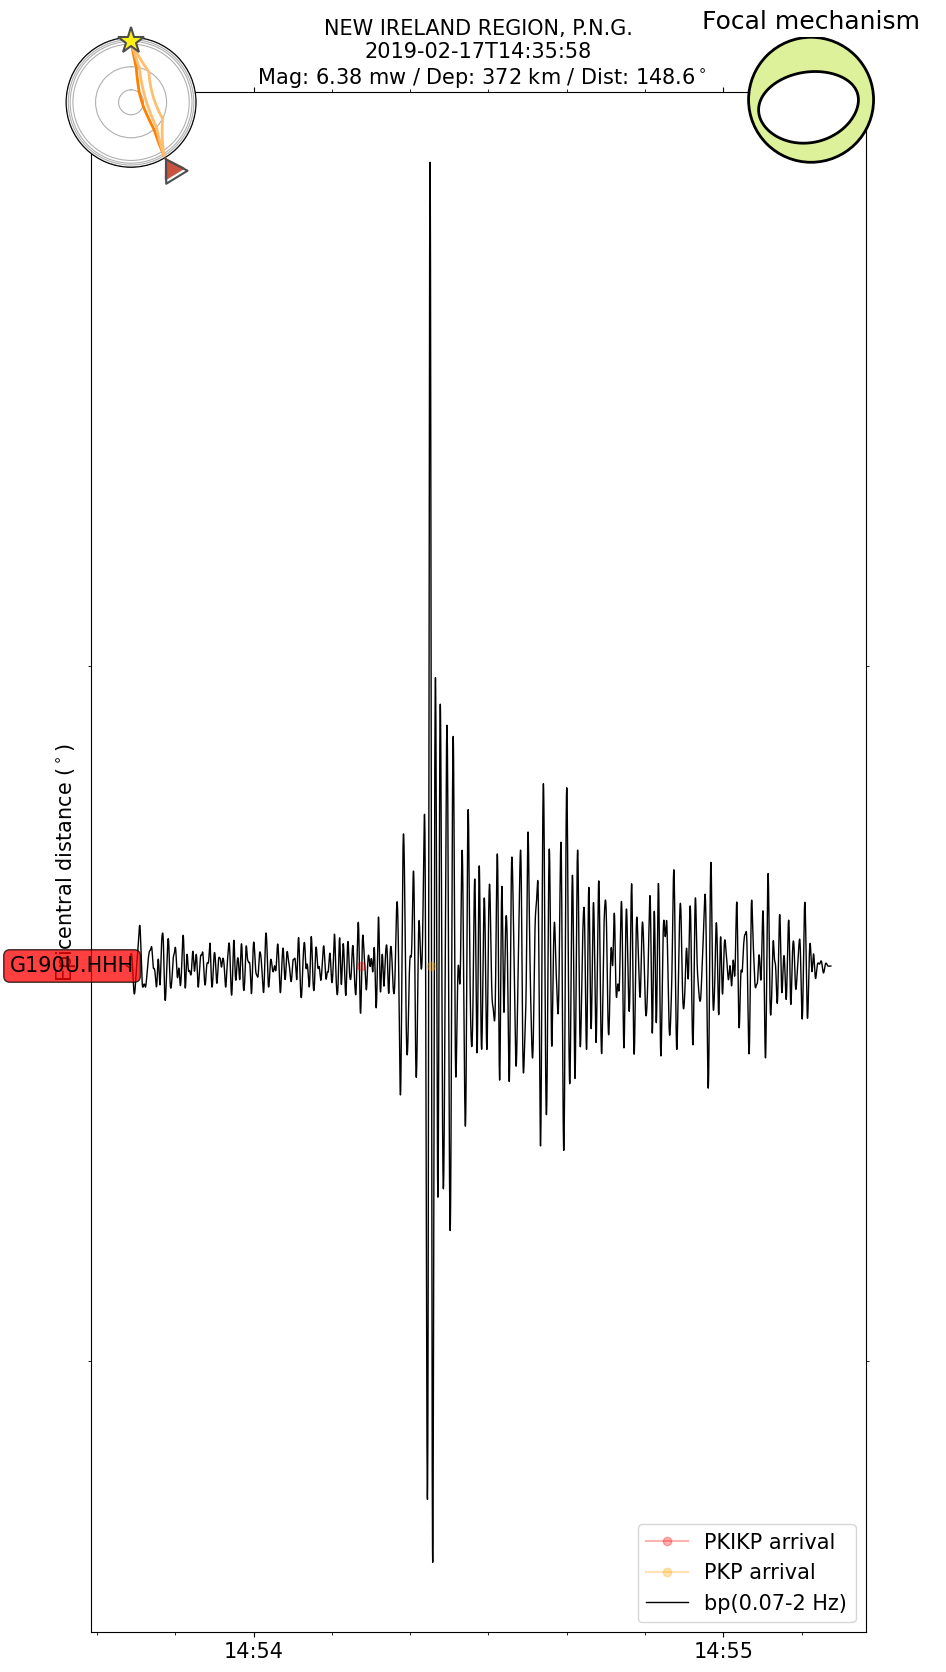

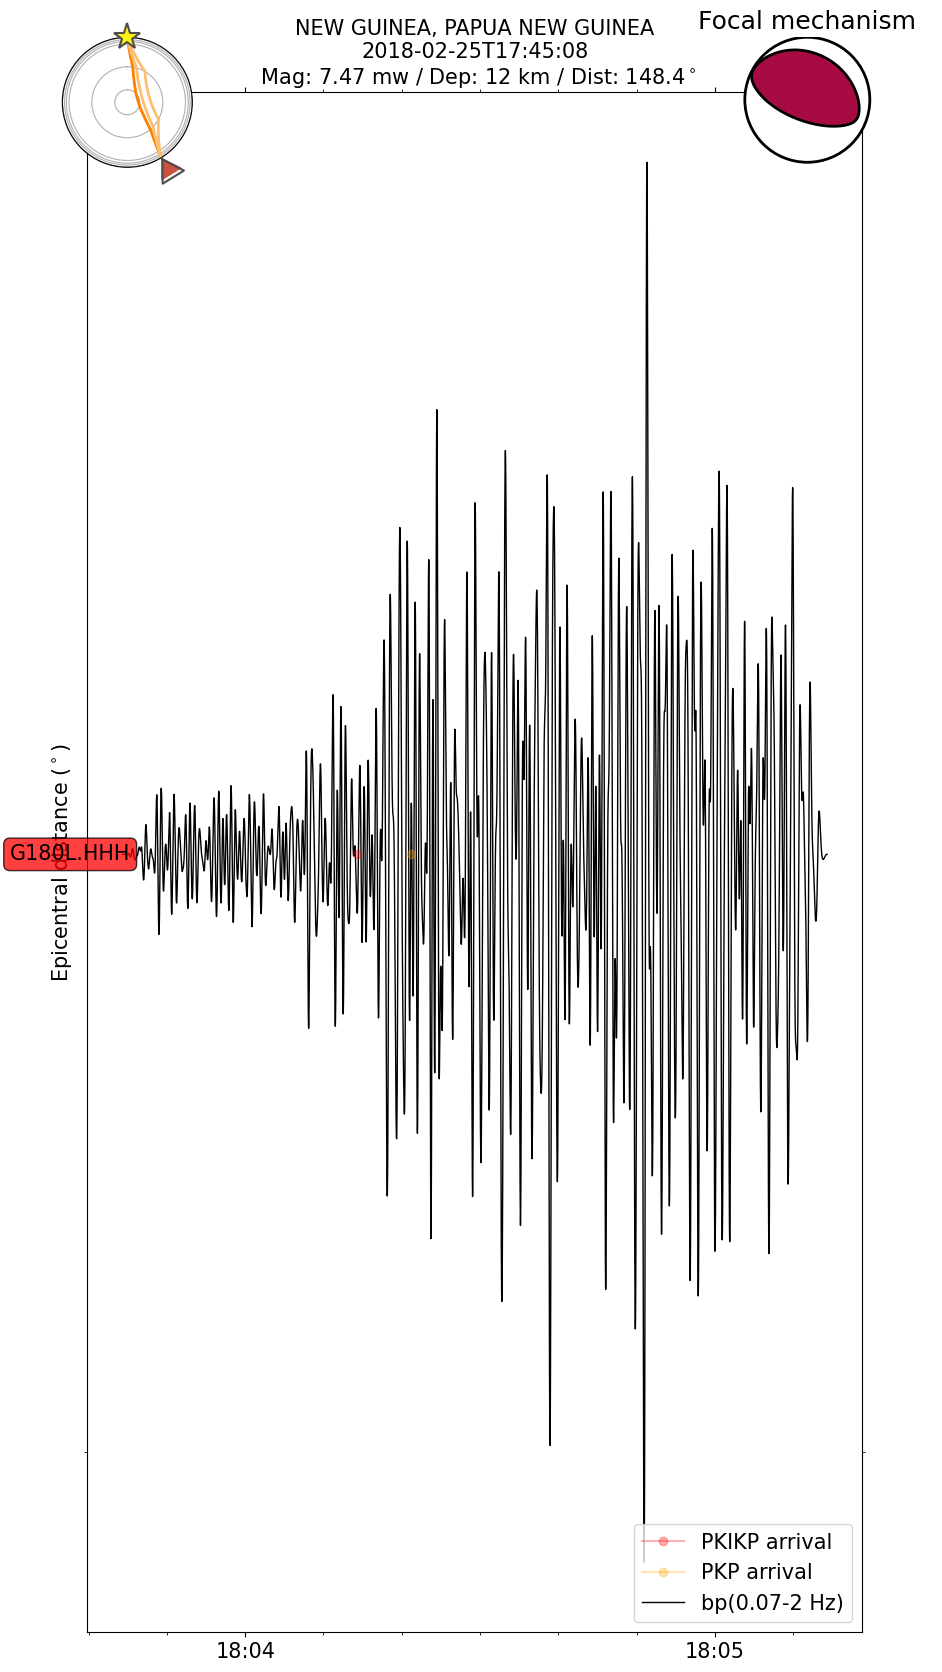

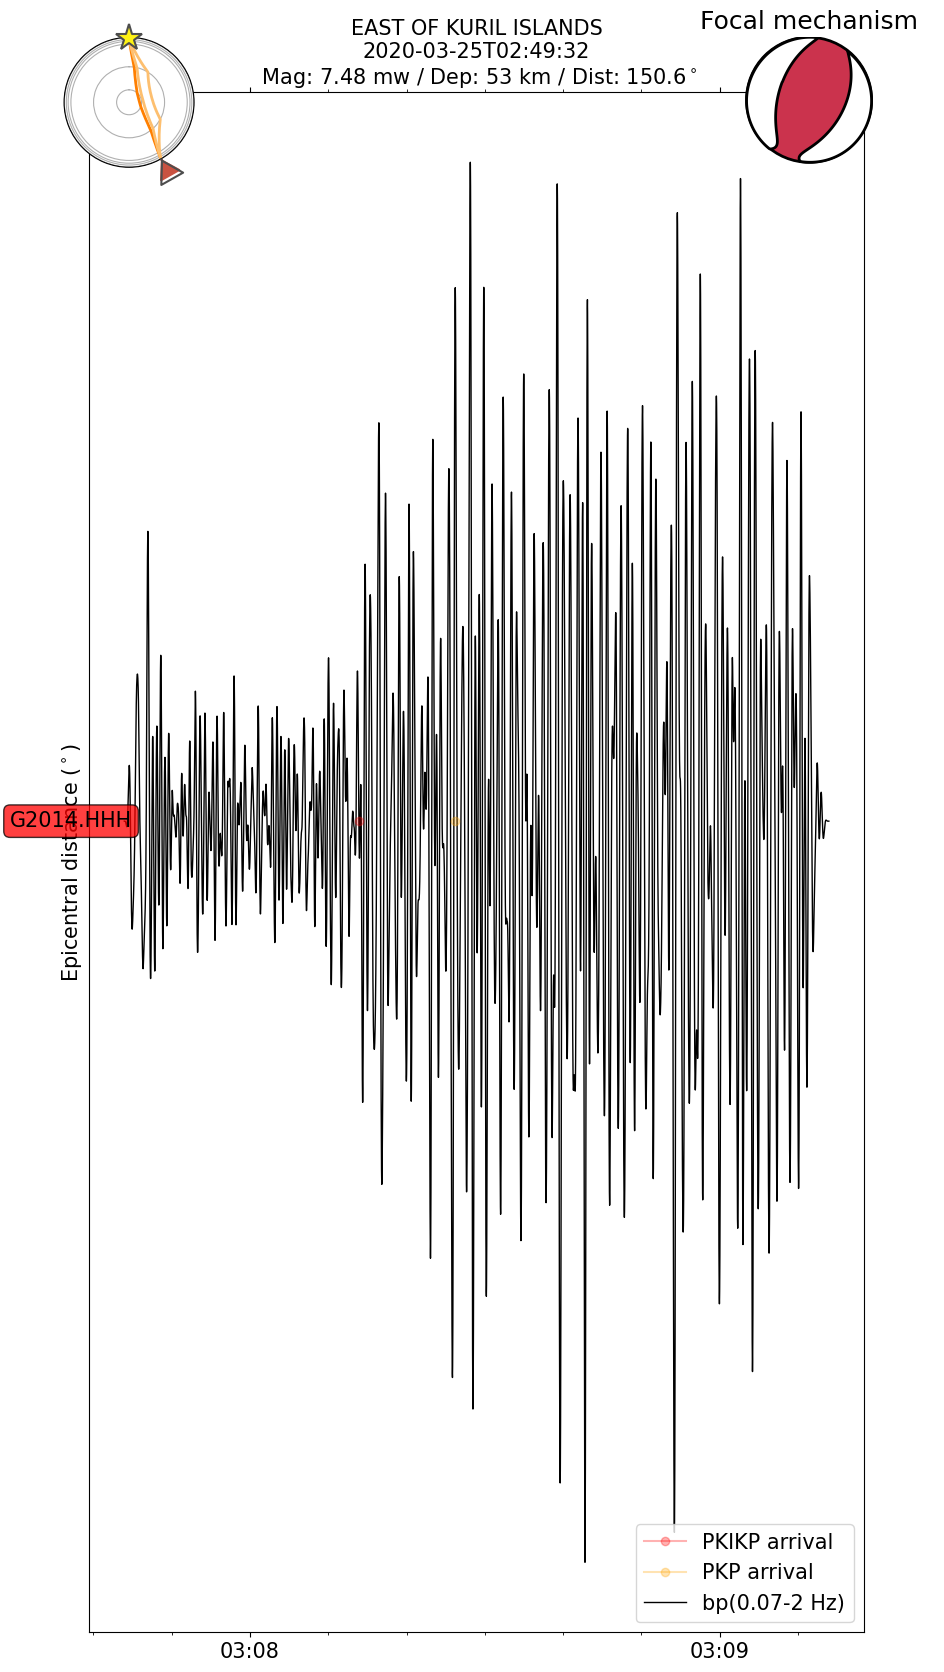

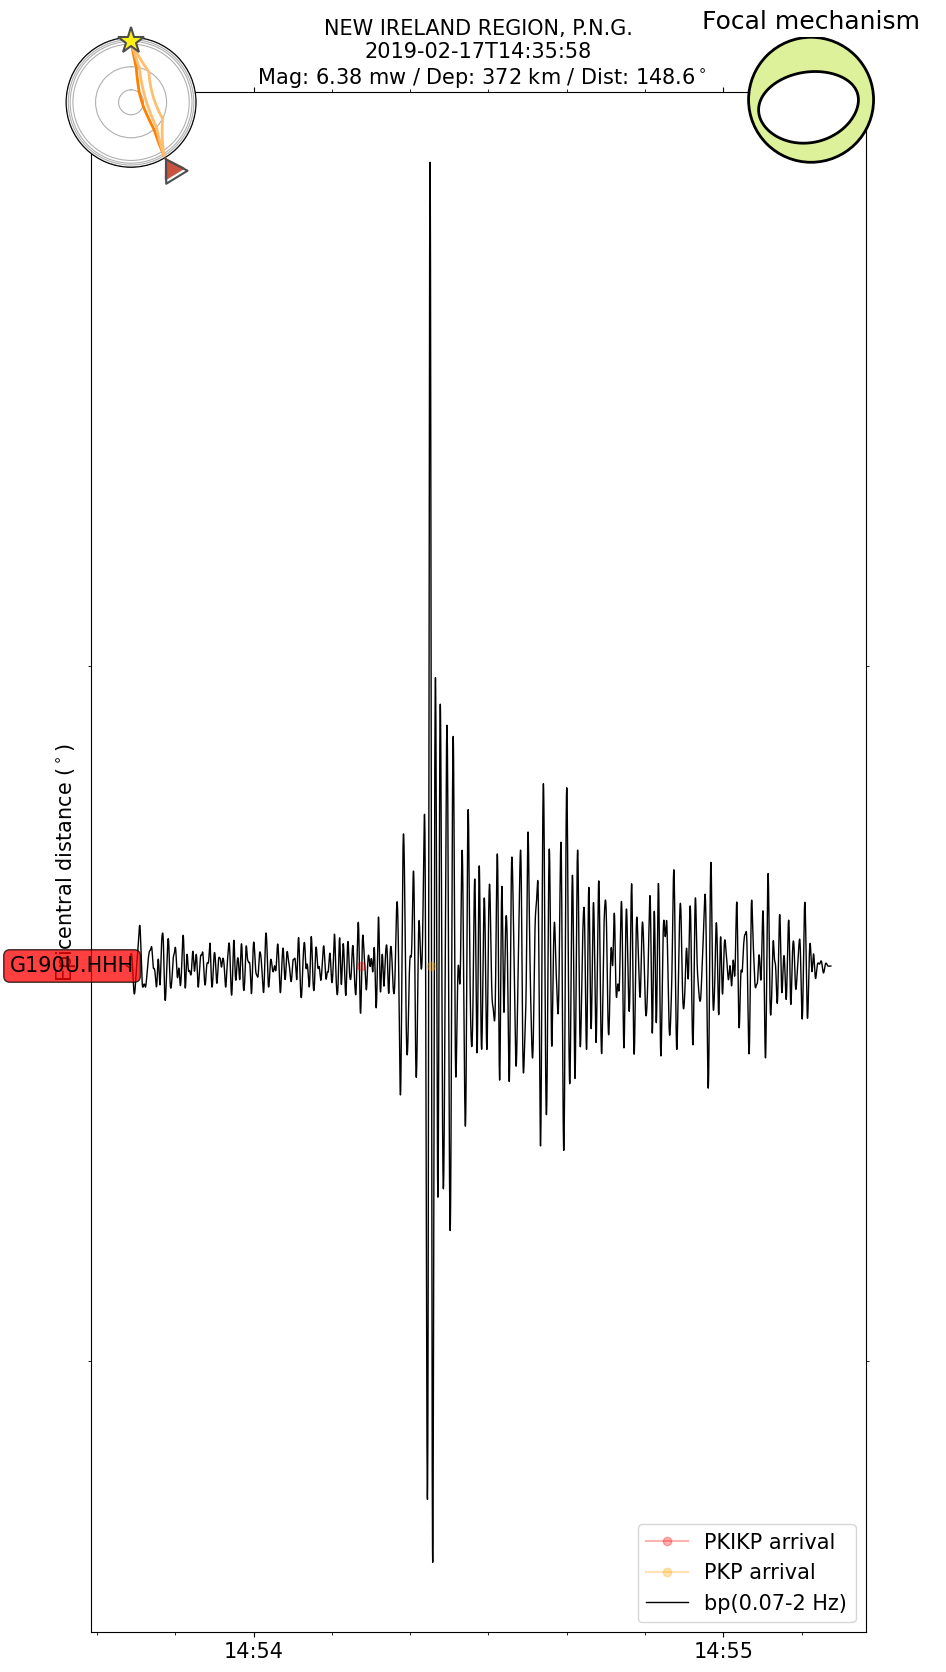

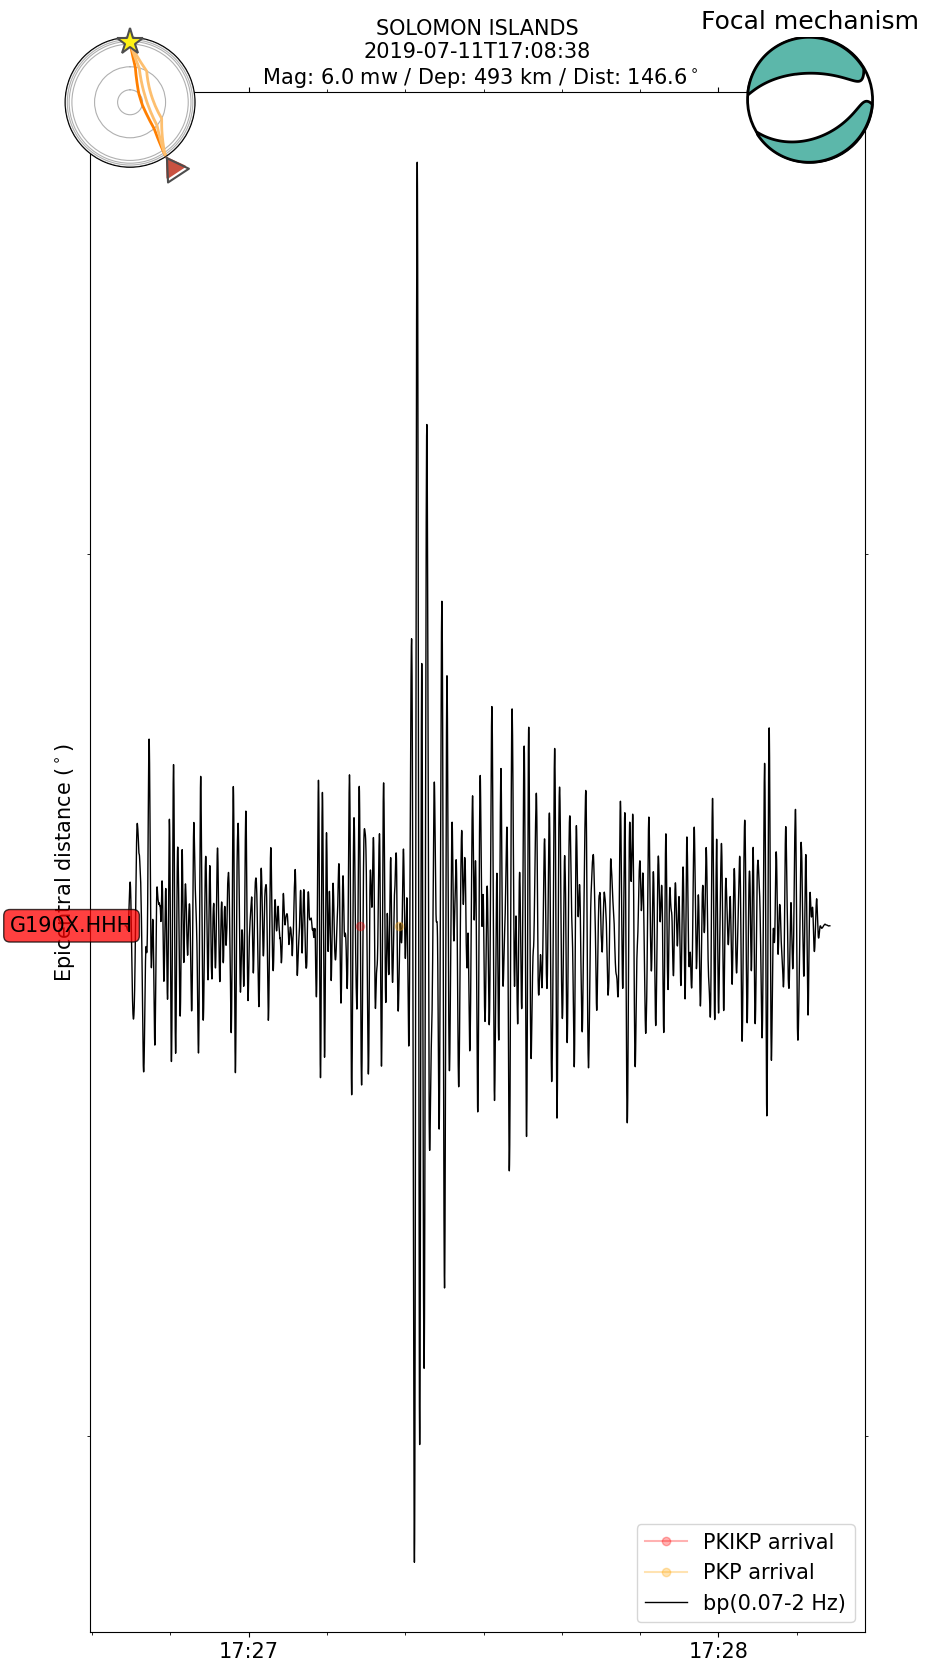

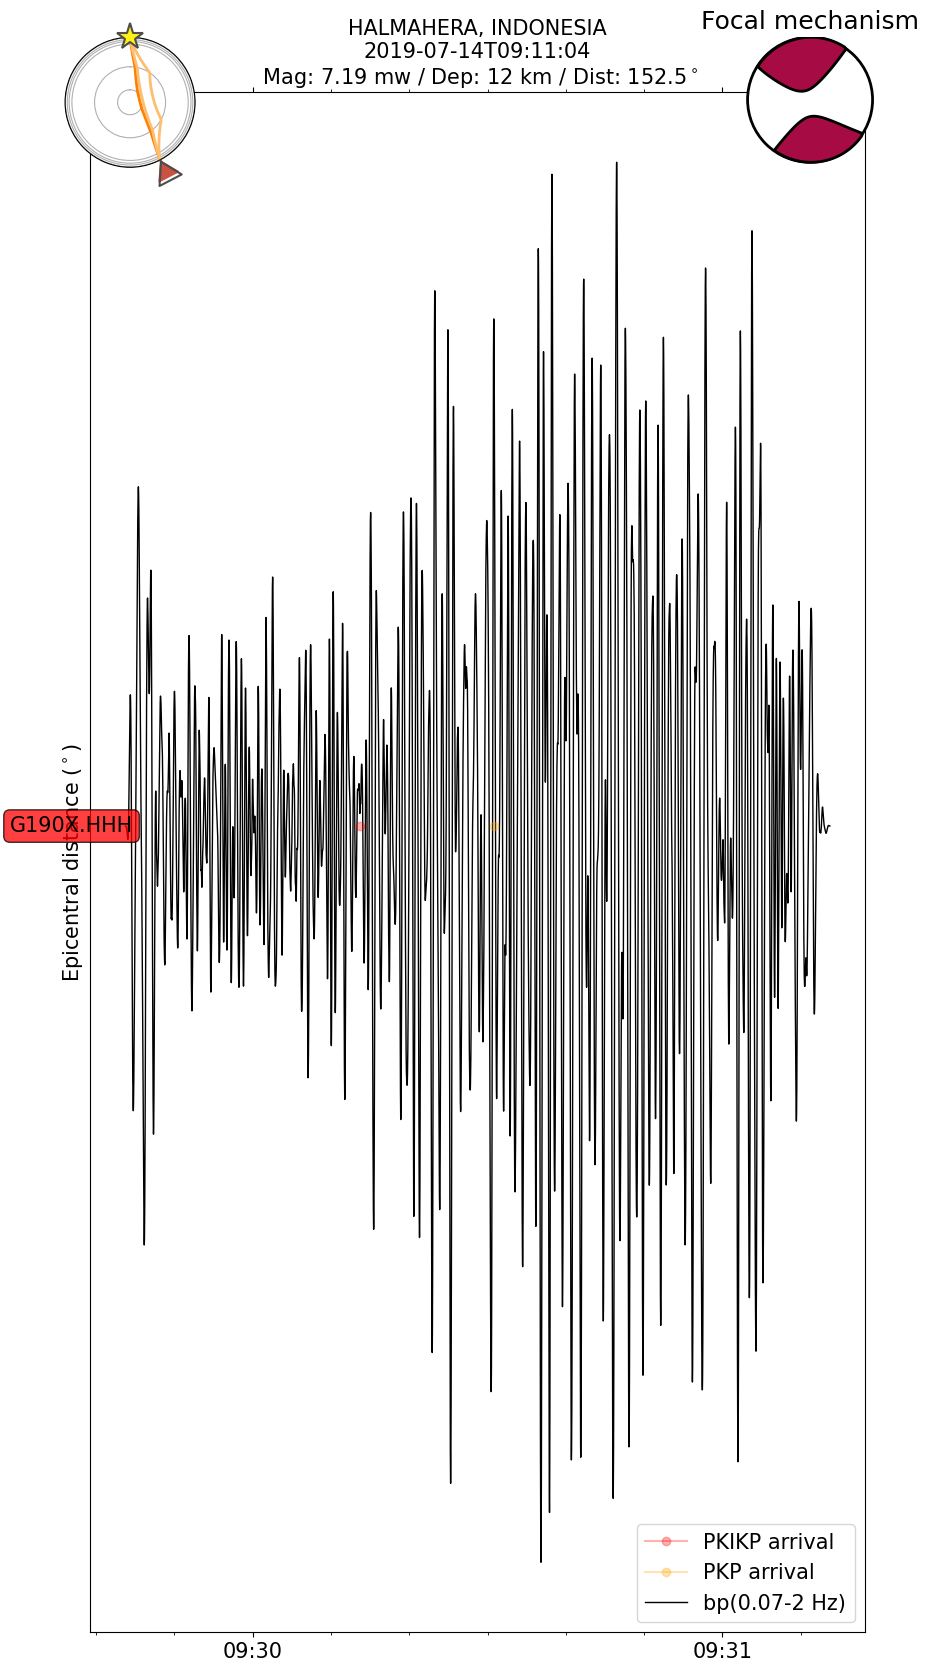

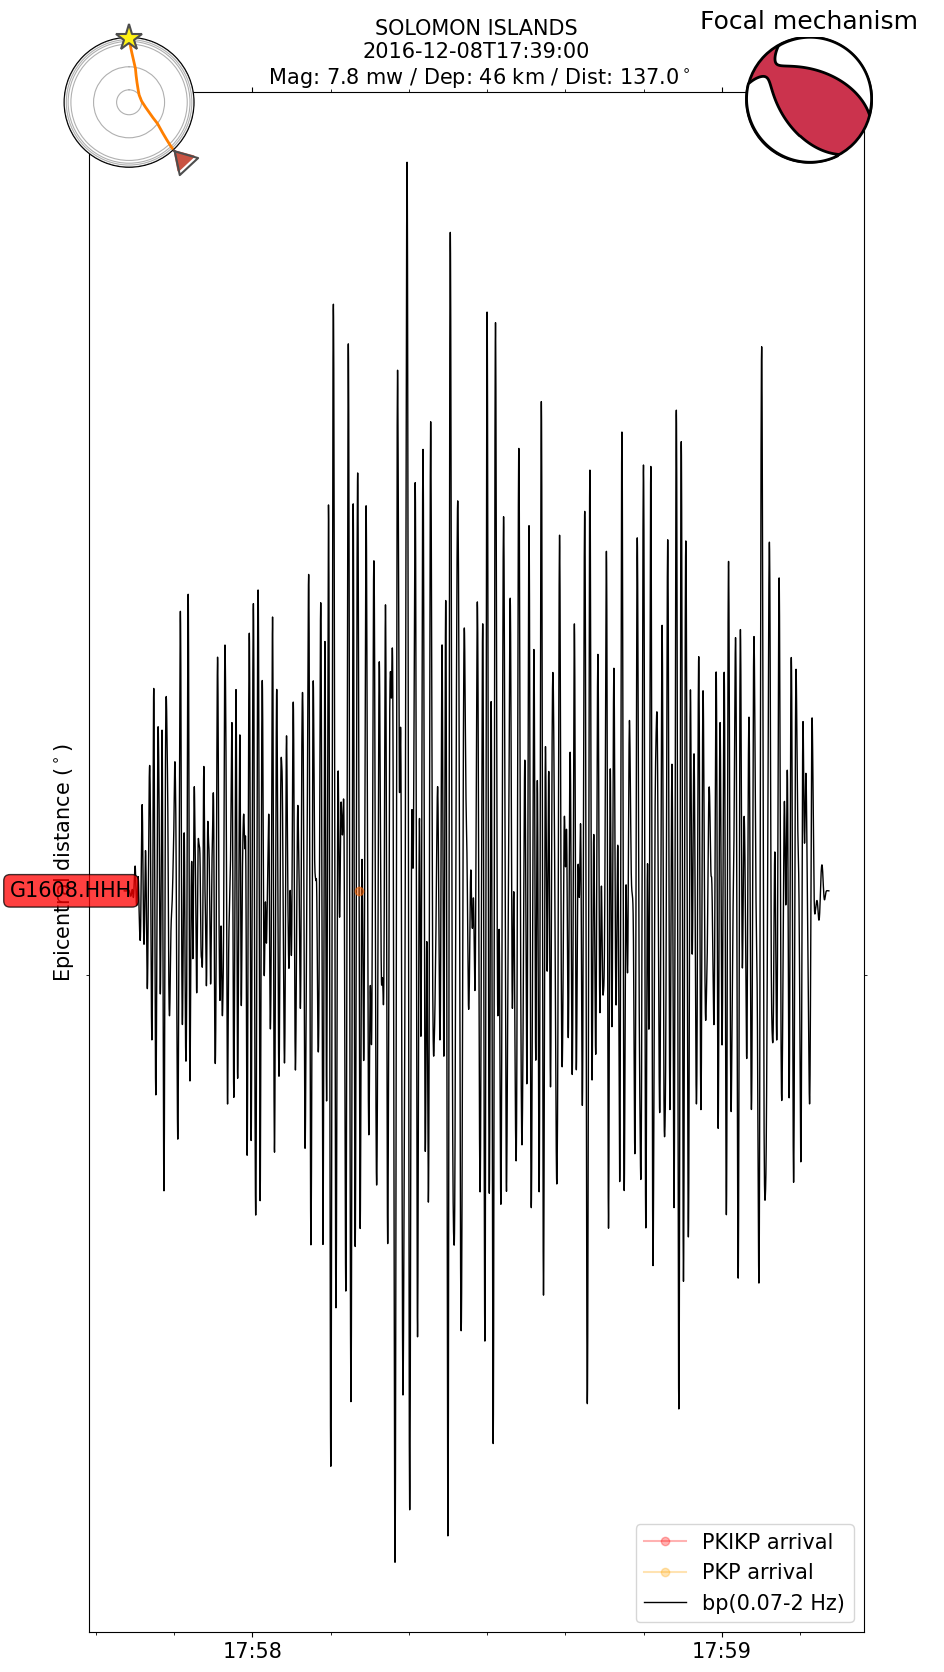

In [28]:
#########################################################################################################################################################
#Figure REGIONAL
# Setting: Global font size
mpl.rcParams.update({'font.size': 15})

for i in df.iterrows():
    #try:        
        glider = glob(EVENT_GLIDER+i[1]['filename_mseed'].split('.')[0]+'/'+i[1]['name_glider']+'/'+str(UTCDateTime(i[1]['ev_time']).year)+'/'+'{:03}'.format(UTCDateTime(i[1]['ev_time']).julday)+'/'+UTCDateTime(i[1]['ev_time']).strftime('%Y.%j.%H.%M')+'*/*')
        rsbr = glob(EVENT_RSBR+'*/*/'+str(UTCDateTime(i[1]['ev_time']).year)+'/'+'{:03}'.format(UTCDateTime(i[1]['ev_time']).julday)+'/'+UTCDateTime(i[1]['ev_time']).strftime('%Y.%j.%H.%M')+'*/*.Z')

        event = i[1]['ev_time']
        ev_lat = i[1]['ev_lat']
        ev_long = i[1]['ev_long']
        ev_depth = i[1]['ev_depth']
        magnitude = i[1]['magnitude']
        magnitude_type = i[1]['magnitude_type']
    
        # set up the plot and create a GeoAxes:
        fig = plt.figure(figsize=(10,20))
        ax = fig.add_subplot()
        
        # ============= #
        # RSBR STATIONS
        # ============= #
        '''
        for st_file in rsbr:
            st_plot = obspy.read(st_file)[0]
            
            gcarc = st_plot.stats.sac.gcarc
    
            #Event time at each station
            #Calculating distance, azimuth and backazimuth
            model = TauPyModel(model='prem')

            if i[1]['Phase'] == 'PKIKP' or i[1]['Phase'] == 'PKP':
                arrival = model.get_travel_times(source_depth_in_km=ev_depth,distance_in_degree=gcarc,phase_list=['PKP','PKIKP'])
                event_time = UTCDateTime(i[1]['ev_time'])+arrival[0].time
                event_time_PKP = UTCDateTime(i[1]['ev_time'])+arrival[-1].time
                ax.plot(event_time.matplotlib_date,gcarc,c='r',marker='o',alpha=0.3,zorder=10)
                ax.plot(event_time_PKP.matplotlib_date,gcarc,c='orange',marker='o',alpha=0.3,zorder=10)
            else:
                arrival = model.get_travel_times(source_depth_in_km=ev_depth,distance_in_degree=gcarc,phase_list=['P','pP'])
                event_time = UTCDateTime(i[1]['ev_time'])+arrival[0].time
                event_time_pP = UTCDateTime(i[1]['ev_time'])+arrival[1].time
                ax.plot(event_time.matplotlib_date,gcarc,c='r',marker='o',alpha=0.3,zorder=10)
                ax.plot(event_time_pP.matplotlib_date,gcarc,c='orange',marker='o',alpha=0.3,zorder=10)
                
            st_plot.trim(event_time-30,event_time+60)
            if len(st_plot) > 0:
                st_plot.filter('bandpass',freqmin=0.7,freqmax=2, corners=4, zerophase=False)
                st_plot.taper(max_percentage=0.05, type='cosine')      
                st_plot.detrend('linear')
                st_plot.detrend('demean')
                               
                ax.plot(st_plot.times('matplotlib'),gcarc+preprocessing.normalize([st_plot.data])[0]*10,c='grey',ls='-',lw=0.5)
                ax.text(x=st_plot.times('matplotlib')[-1],y=st_plot.stats.sac.gcarc,s=st_plot.stats.station+'.'+st_plot.stats.channel,ha="center",va="center",bbox=dict(boxstyle="round",ec='k',fc='w',alpha=0.5))
        '''  
        for st_file in glider:
            st_plot_glider = obspy.read(st_file)[0]
        
            gcarc_glider = st_plot_glider.stats.sac.gcarc
            
            #Event time at each station
            #Calculating distance, azimuth and backazimuth

            model = TauPyModel(model='prem')
            if i[1]['Phase'] == 'PKIKP' or i[1]['Phase'] == 'PKP':
                arrival = model.get_travel_times(source_depth_in_km=ev_depth,distance_in_degree=gcarc_glider,phase_list=['PKP','PKIKP'])
                event_time_glider = UTCDateTime(i[1]['ev_time'])+arrival[0].time
                event_time_glider_PKP = UTCDateTime(i[1]['ev_time'])+arrival[-1].time
                ax.plot(event_time_glider.matplotlib_date,gcarc_glider,c='r',marker='o',alpha=0.3,label='PKIKP arrival',zorder=10)
                ax.plot(event_time_glider_PKP.matplotlib_date,gcarc_glider,c='orange',marker='o',alpha=0.3,label='PKP arrival',zorder=10)
            else:
                arrival = model.get_travel_times(source_depth_in_km=ev_depth,distance_in_degree=gcarc_glider,phase_list=['P','pP'])
                event_time_glider = UTCDateTime(i[1]['ev_time'])+arrival[0].time
                event_time_glider_pP = UTCDateTime(i[1]['ev_time'])+arrival[1].time
                ax.plot(event_time_glider.matplotlib_date,gcarc_glider,c='r',marker='o',alpha=0.3,label='P arrival',zorder=10)
                ax.plot(event_time_glider_pP.matplotlib_date,gcarc_glider,c='orange',marker='o',alpha=0.3,label='pP arrival',zorder=10)

            st_plot_glider.trim(event_time_glider-30,event_time_glider+60)
            if len(st_plot) > 0:
                st_plot_glider.filter('bandpass', freqmin=0.7,freqmax=2, corners=4, zerophase=False)
                st_plot_glider.taper(max_percentage=0.05, type='cosine')     
                st_plot_glider.detrend('linear')
                st_plot_glider.detrend('demean')
            
                ax.plot(st_plot_glider.times('matplotlib'),gcarc_glider+preprocessing.normalize([st_plot_glider.data])[0]*10,c='k',ls='-',lw=1,label='bp(0.07-2 Hz)')
                ax.text(x=st_plot_glider.times('matplotlib')[100],y=gcarc_glider,s=st_plot_glider.stats.station+'.'+st_plot_glider.stats.channel,ha="right",va="center",bbox=dict(boxstyle="round",ec='k',fc='r',alpha=0.75))

        ax.set_title(i[1]['local']+'\n'+UTCDateTime(i[1]['ev_time']).strftime('%Y-%m-%dT%H:%M:%S')+'\n Mag: '+str(magnitude)+' '+magnitude_type+' / Dep: '+str(round(ev_depth))+' km / Dist: '+str(round(gcarc_glider,1))+'$^\circ$',fontsize=15)
        ax.set_ylabel('Epicentral distance ($^\circ$)')
        ax.legend(loc='lower right')
        ax.xaxis.set_major_locator(mdates.SecondLocator(interval=60))
        ax.xaxis.set_minor_locator(mdates.SecondLocator(interval=10))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax.yaxis.set_major_locator(MultipleLocator(5))
        ax.yaxis.set_minor_locator(MultipleLocator(1))
        ax.xaxis.set_ticks_position('both')
        ax.yaxis.set_ticks_position('both')

        # ----------------------------------------------------------------------------------------------------------
        # focal mechanisms
        # ----------------------------------------------------------------------------------------------------------

        # Plotting: graphical representation of a focal mechanism (https://docs.obspy.org/packages/autogen/obspy.imaging.beachball.beachball.html)

        # Normalize event depth values between 0 and 600 km:
        min_val = 0
        max_val = 600
        normalized_values = [(x - min_val) / (max_val - min_val) for x in np.arange(min_val, max_val,10)]

        # Colormap "Plasma" for each value
        colors = [plt.cm.Spectral(value) for value in normalized_values]
                                                                        
        # Convert colors RGB to hexadecimal:
        hex_colors = [mcolors.rgb2hex(color) for color in colors]

        # Find the color for a given depth
        diff_ev_depth = [np.abs(numero - ev_depth) for numero in np.arange(min_val, max_val,10)]
                                        
        # Find the min index for a given depth
        index_min_ev_depth = diff_ev_depth.index(min(diff_ev_depth))
    
        # -------------------------
    
        newax = fig.add_axes([0.72, 0.72, 0.25,  0.25])
    
        moment_tensor = ast.literal_eval(i[1]['moment_tensor'])
        mrr = moment_tensor[0]
        mtt = moment_tensor[1]
        mpp = moment_tensor[2]
        mrt = moment_tensor[3]
        mrp = moment_tensor[4]
        mtp = moment_tensor[5]
        mt = [mrr, mtt, mpp, mrt, mrp, mtp]
    
        # Plotting the hexcolor
        bball = beach(fm=mt, xy=(0, 0.5),size=500, width=1, facecolor=hex_colors[index_min_ev_depth])
            
        # Configura os eixos e adiciona a coleção
        newax.add_collection(bball)
        newax.set_xlim(-1, 1)
        newax.set_ylim(-1, 1)
        newax.set_aspect('equal')
        newax.axis('off')
        newax.set_title('Focal mechanism')

        
        # ===========================================================
        # ray paths (https://docs.obspy.org/packages/obspy.taup.html)
        # ===========================================================
        
        # ---------------------------------------------------------------------------------------------------
        # Computing: The paths travelled by the rays to the receiver for a given phase and 1D velocity model 
                    
        arrivals_ray_path = model.get_ray_paths(source_depth_in_km=ev_depth, distance_in_degree=gcarc_glider, phase_list=['P','pP','PKP','PKIKP'])

        # -------------------------
        # Plotting: axes parameters 
                                    
        ax_raypath = fig.add_axes([0.1, 0.81, 0.13,  0.13], projection='polar')
        arrivals_ray_path.plot_rays(ax=ax_raypath)
        ax_raypath.set_title('Ray path',y=1.08)
   
        # ----------------------------------------------------------------------------------------------------------
        # Saving figure
        os.makedirs(FOLDER_OUTPUT+'EVENTS/FIGURES/REGIONAL/',exist_ok=True)
        fig.savefig(FOLDER_OUTPUT+'EVENTS/FIGURES/REGIONAL/'+'event_mseed_'+UTCDateTime(i[1]['ev_time']).strftime('%Y-%m-%dT%H:%M:%S')+'_'+i[1]['ev_ID']+'.png',pad_inches=0.01,dpi=100)
        #plt.close()
    #except:
        #pass
